In [92]:
import os
import codecs
import glob
import logging
import re
import sys
import string
import warnings
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.utils import resample
from sklearn.feature_selection import SelectKBest
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn import preprocessing
from sklearn.decomposition import PCA as sklearn_pca
from sklearn import decomposition
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_selection import RFECV
import bokeh.plotting as bp
import matplotlib as mpl
from scipy.stats import mode
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.cluster import SpectralClustering, MeanShift, estimate_bandwidth, AffinityPropagation, KMeans
from sklearn.preprocessing import Normalizer, normalize
from sklearn.manifold import TSNE
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score, completeness_score, v_measure_score, adjusted_rand_score
from sklearn.model_selection import train_test_split,cross_val_score, KFold, cross_val_predict, GridSearchCV, StratifiedKFold
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
import tensorflow as tf
import keras
from keras.layers import Embedding,LSTM, Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, Input
from keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras import backend as K
%matplotlib inline

### Introduction ###

The purpose of this product is to classify population depending on their uses of their phone and phone brands. This classification is the first step to tailor advertising campaigns by third parties based on the usage of the mobile according to the age and gender of the population. For this we have a sample of the population using Mobile Talk data in China. Although this product has been developed for the Chinese population, it can be used globally as further research has shown that other mobile operators in other countries have access to the same type of data.

In this case the groups have been preset based on gender and age range that are specifically important for the client of Mobile Talk. This groups can be tailored to the needs of the advertising company depending on the information that the mobile operator is willing to share with the final client or that wants to use to tailor its own offering.

From the data extracted we are going to get the main features that will be used to classify the population according to their demographics. For this we are going to focus on the apps they use and the device brand. The steps that will be followed to develop this product are:

1. ***Data Wrangling:*** Acquire the data and transform categorical data into data that can be used for classification after merging the data from different sources. In this step special attention has been taken to the empty cells and duplicates present in each dataset so that the final dataset is manageable.

2. ***Dataset creation:*** Build the final dataset and cleanse it accordingly so that it can be used for classification purposes. In this case the categorical features are hotenconded representing by 1 the presence of an app on a device and zero the absence. The same criteria has been followed with the phone brand. In this case, brands have been translated into English using information available. Local brands, for which information was not available have been substituted with UBXX standing for “unkown brand” followed by two digits.

3. ***Features Generation:*** The most meaningful features have been selected using different methods and transformed using PCA so that the classification accuracy is maximized. The initial analysis to generate the features give the most important ones to measure the relationship they have with the outcome variable (group by gender and age). For the classification purposes there is no need to keep them as accuracy is the objective of the classification exercise. In this case kbest, random forest feature selection and recursive feature elimination has been used as a preliminary step. The final number of features to determine the PCA components have been chosen so that the accuracy of the algorithms in enhanced.

4. ***Model Selection:*** Several supervised algorithms have been used as a preliminary step to determine the one that is giving highest accuracy and that is suitable for production. Computing effort and suitability for production is measured based on the computing time required by each of them. There is a compromise that has to be achieved between accuracy and computing effort to make the product a feasible product. The algorithms that will be tested are logistic regression, Naïve-Bayes, k-nearest neighbors, support vector classifier, linear vector classifier, random forest, decision tree, SGD classifier and Gradient Boosting classifier. From the obtained results the algorithm that suits best the abovementioned criteria will be selected as final product.

5. ***Deep learning classification:*** in this case, the raw data is passed through a Multilayer Classifier analyzing the effect of different layers and configurations of the neural network to maximize the accuracy of the model. In this case due to the amount of data points available we are expecting high accuracy but maybe lower than the accuracy that is normally obtained with this models. The goal is to achieve the highest accuracy through this model.

6. ***Unsupervised Clustering:*** Cluster the data to see the information that it can be extracted from it and the basic features that characterize each group. Meanshift, Spectral, Affinity and kmeans clustering will be tested to see which one is the most suitable based on the different metrics used for comparison such as silhouette, homogeneity, completeness, V-measure and adjusted Rand. The number of clusters between spectral clustering and kmeans that achieves the best result is the one that will be used to cluster the information.

7. ***Conclusion*** The main findings will be summarized and the selected algorithm will be presented as a conclusion summarising the main features of the product.

### 1. Data Wrangling###

The data that is going to be used is retrieved from https://www.kaggle.com/c/talkingdata-mobile-user-demographics. In this case, we have several folders that give information about demographics and use of their mobile phones. More specifically, we will focus on the gender-age file as the base to create the features for further analysis. This file contains the information and clusters that are relevant to be used for online advertising campaigns, including device id, age, gender and age group.

The dataset provided by Kaggle as the test in the abovementioned link has been discarded as it is providing devices that are not contained in the training dataset and is adding noise to the dataset as we don´t have any relevant information from which we can create features.

The phone brand dataset is linking the device id with the phone brand and model. The device model will be used and grouped by phone brand to use it as one of the features. In this case and for further merging of the datasets the duplicates in phone brands have been dropped as it will increase the dataset making it unmanageable not adding information.

The appevents dataset links the events or usage of the different apps to the app id that categorizes the apps within certain groups such as gaming, finance, etc. In this case the app ides will be used as a categorical features to have a better description of the interests of the target audience. The linking column will be the events as it appears in both datasets (app_events and device apps) including information about the app to see if it is active or just installed.

The applabels dataset “translates” a 20 digits id into the abovementioned categories.

The events dataset gives information about the location and the time in which the app is used in the device. In this case the information about the location has been discarded as it is not accurate giving as locations points outside of China hence not adding relevant information for the features generation.

In [2]:
#Uplaod the data into the notbook and select the rows that will be used after previous visual inspection of the datasets
datadir = 'D:/Users/Borja.gonzalez/Desktop/Thinkful-DataScience-Borja'
gatrain = pd.read_csv('gender_age_train.csv',usecols=['device_id','gender','age','group'] )
gatest = pd.read_csv('gender_age_test.csv')
phone = pd.read_csv('phone_brand_device_model.csv')
app_events = pd.read_csv('app_events.csv', usecols = ['event_id', 'app_id','is_active'])
applabels = pd.read_csv('app_labels.csv')
events = pd.read_csv('events.csv', usecols = ['event_id', 'device_id'])

# Get rid of duplicate device ids in phone
phone = phone.drop_duplicates('device_id',keep='first')

### 2. Dataset Creation ###

The first objective is to create a dataset that unifies the different files that have been uploaded into the notebook. For this there will be a set of merging actions based on the information provided that will be combined with cleaning actions to avoid oversizing the final dataset prior to the features generation.

To merge this information the hypothesis around the potential features that can explain the demographics of the users for further classification has been used: app labels, device brands, gender and age. This transforms the problem into selecting and generation the categorical features (predictors) to determine based on them if the user is in a certain age range and gender (target).

The order in which the different datasets are merged is not random. Several ways of merging the data have been tried and this is the one that allows to build a model that will predict the age range and gender gathering as much relevant information as possible.

In this case the information about events (usage of the phone) and app_events that identifies app ids is merged using as the merging column the events. As a result information about the device id the use of the app and the app id are in the same dataframe which allows further merging to arrive to the applabels and device brands. In this merging the duplicates have been left out to avoid oversizing the dataframe. From the information of this dataset there are 459k rows of data that match usage, device id to app id. The timestamp has been eliminated from the dataset as it does not add relevant information and there are data points missing.

In [3]:
#Merge the app_events and events to accrss app_ids.
device_apps = (
     
     app_events
    
     # Merge on event_id
    .merge(events, how = 'left', left_on = 'event_id', right_on = 'event_id')
    
     # event_id itself is not interesting
    .drop('event_id', axis = 1)
    
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates())

The dataset stands as follows. There are more than 2.8 million entries being all the values of the cells integers

In [4]:
#Get information about the new dataset
print(device_apps.info())

#Print the first five rows fo the dataset
device_apps.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2840343 entries, 0 to 32472919
Data columns (total 3 columns):
app_id       int64
is_active    int64
device_id    int64
dtypes: int64(3)
memory usage: 86.7 MB
None


,app_id,is_active,device_id
0,5927333115845830913,1,-6401643145415154744
1,-5720078949152207372,0,-6401643145415154744
2,-1633887856876571208,0,-6401643145415154744
3,-653184325010919369,1,-6401643145415154744
4,8693964245073640147,1,-6401643145415154744


The devices ids are now linked to the applabels so that it contains the information about the different categories of the apps is included. In this case the 20 digit identifier of the app is substituted by a category that identifies the kind of app that is active in each device.

In [5]:
#Translate the apps_id to apps categories to build features
apps = (
    device_apps
    
     # Merge on event_id
    .merge(applabels, how = 'left', left_on = 'app_id', right_on = 'app_id')
    
     # event_id itself is not interesting
    .drop('app_id', axis = 1)
    
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates())

The new dataset is cleansed removing the empty values and changing the type of variable so that they can be merged afterwards without increasing disproportionately the number of rows.

In [6]:
#Clean the dataset removing empty cells from the data set
apps = apps.dropna()

#convert first or second to str or int
apps['device_id'] = apps['device_id'].astype(int)
#Motor['Motor'] = Motor['Motor'].astype(str)

#Merge the column back into the dataset
gatrain['device_id'] = gatrain['device_id'].astype(int)

Information is retrieved about the size and type of the variables in the dataset. The dataset is now ready to be merged.

In [7]:
#Get information of the new dataset and chekc tha the transformation into integers has happened before
#merging datasets
print(apps.info())

#Print the first five rows of the dataframe
apps.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5977729 entries, 0 to 18279373
Data columns (total 3 columns):
is_active    int64
device_id    int64
label_id     int64
dtypes: int64(3)
memory usage: 182.4 MB
None


,is_active,device_id,label_id
0,1,-6401643145415154744,549
1,1,-6401643145415154744,710
2,1,-6401643145415154744,704
3,1,-6401643145415154744,548
4,1,-6401643145415154744,172


The dataset containing data about the usage of the apps, the activity, device id is linked with the dataset containing the device id and information about the gender, age and age group. The age groups used are the ones provided in the dataset and have not been changed.

There are 12 groups that differentiate the age and gender. The groups roughly split the population in even groups and the distribution of data points for each group is shown in the following graph.

In [8]:
#Merge dataset about devices and apps with demographic data
apps_with_groups = (
    apps
    
     # Merge on event_id
    .merge(gatrain, how = 'left', on = 'device_id')
    
     # event_id itself is not interesting
   # .drop('device_id', axis = 1)
    
     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates())

Information about the new datasets is retrieved to see the type of variables and to clean the data eliminating any missing cell.

In [9]:
#Get information about the dataset
print(apps_with_groups.info())

#Identify nul values in the dataset
print(apps_with_groups.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5977729 entries, 0 to 5977728
Data columns (total 6 columns):
is_active    int64
device_id    int64
label_id     int64
gender       object
age          float64
group        object
dtypes: float64(1), int64(3), object(2)
memory usage: 319.2+ MB
None
is_active          0
device_id          0
label_id           0
gender       3663482
age          3663482
group        3663482
dtype: int64


Further cleansing is done dropping the empty cells and resetting the index to have a better view of the data points available.

In [10]:
#Drop empty cells
apps_with_groups = apps_with_groups.dropna()

#Reset index in the new dataset
apps_with_groups.reset_index(drop= True)

#Print first five rows
apps_with_groups.head()

,is_active,device_id,label_id,gender,age,group
74,1,1476664663289716375,549,M,19.0,M22-
75,1,1476664663289716375,721,M,19.0,M22-
76,1,1476664663289716375,704,M,19.0,M22-
77,1,1476664663289716375,302,M,19.0,M22-
78,1,1476664663289716375,303,M,19.0,M22-


In the Chinese market the number of apps that is actually used from the ones installed in the devices equate to roughly 50%.

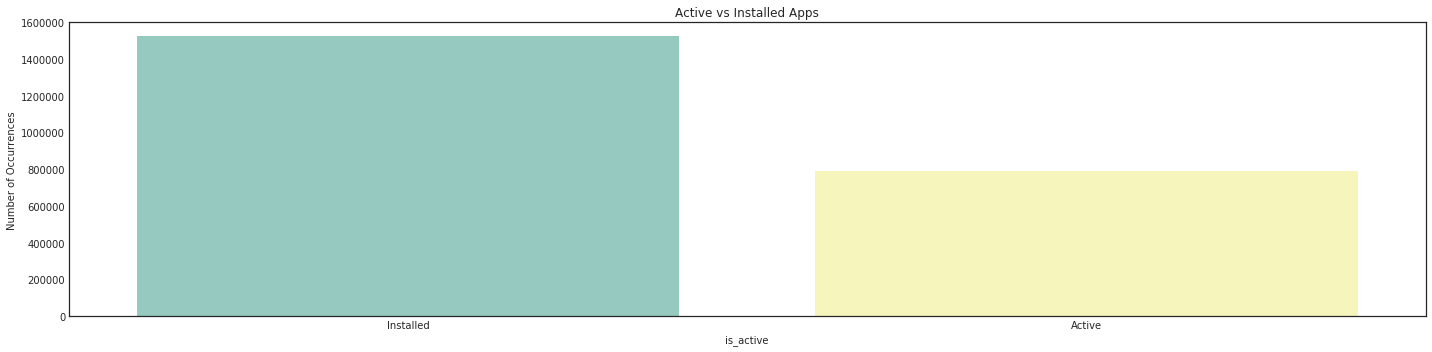

In [11]:
#Plot installed vs active apps

plt.figure(figsize=(20, 5))
sns.set_style("white")
ax = sns.countplot(x="is_active", data=apps_with_groups, palette="Set3")
ax.set_title('Active vs Installed Apps')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(['Installed','Active'], fontsize=10)
plt.tight_layout()
plt.show()

Visual inspection of the distribution of data between ages show that the data is skewed to the right, showing that most of the data represents the age group between 20 and 35 years old. This corresponds to the grouping that has been done age-wise.

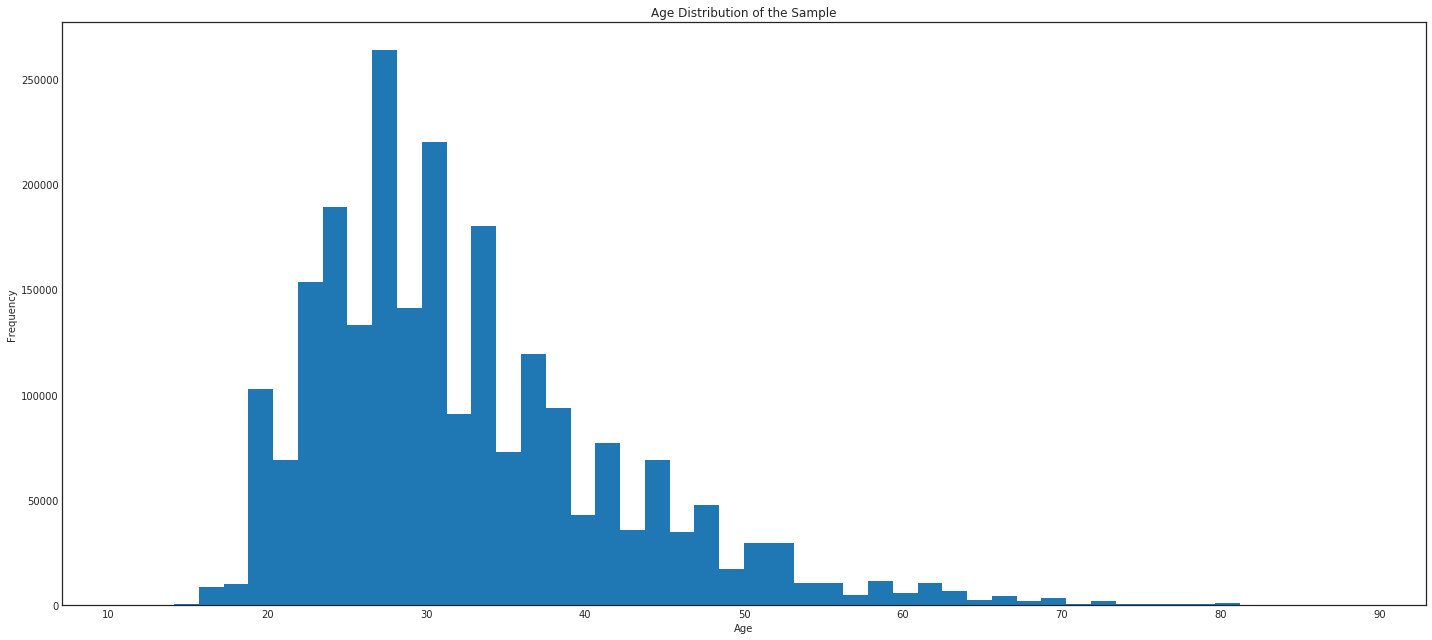

In [12]:
#Plot the distribution of age in the dataset

plt.figure(figsize=(20, 9))
apps_with_groups.age.hist(bins=50, grid = False)
plt.title('Age Distribution of the Sample')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Each group contains 20 apps in total. From an apps usage standpoint, the most important group of apps according to its usage corresponds to financial, lottery and gaming apps followed by apps related to smart appliances and wearables in second place. The third place is taken by the apps used for banking and payment services. On the lower end the apps that show a smaller usage are the leisure related ones like photography, wedding planners or trips abroad. This apps equate to 90 and are presenting a lower usage due to its characteristics and the sample taste.

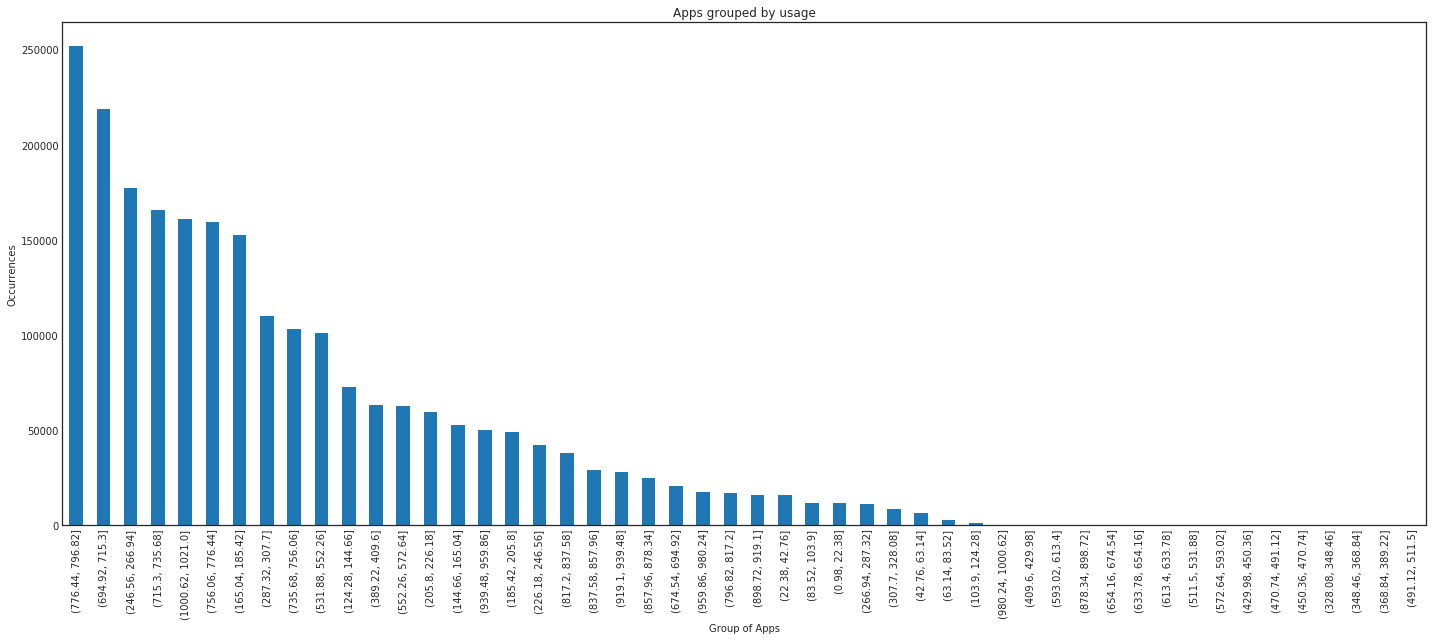

In [13]:
#Plot grouping the apps in different bins to understand its usage.
#Bins range from 10-50 for more detailed analysis

plt.figure(figsize=(20, 9))
apps_with_groups.label_id.value_counts(bins = 50).plot(kind='bar', grid=False)
plt.title('Apps grouped by usage')
plt.xlabel('Group of Apps')
plt.ylabel('Occurrences')
plt.tight_layout()
plt.show()

Dummy variables are created based on the apps that are installed on the devices. In this case 484 additional columns are created with categorical data that counts the appearance of each app category in the device. To avoid the dummy variable trap whereby collinearity exists between the variables one redundant category is dropped when transforming the categorical variables into dummies.

In [14]:
#Create dummy variables for the categories found in the apps
dataset_with_dummy_variables = pd.get_dummies(apps_with_groups, columns = ['label_id'], sparse = True).reset_index(drop= True)

#Print the first 5 rows of data
dataset_with_dummy_variables.head()

,is_active,device_id,gender,age,group,label_id_2,label_id_4,label_id_6,label_id_7,label_id_8,...,label_id_1012,label_id_1013,label_id_1014,label_id_1015,label_id_1016,label_id_1017,label_id_1018,label_id_1019,label_id_1020,label_id_1021
0,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Before adding the data about the phone brands and models, a dictionary has been taken from Kaggle and augmented with additional brands to translate the brands from Chinese to English. Additionally, those brands that have no translation have been designed with “UBXX” where UB stands for unknown brand and XX are two digits. This has been done to easy queries on the dataframe and visualizations of the dataset. The translation of the brands form Chinese to English has been included in the phone dataset and dummy variables have been created for each brand. This gives as a result a sparse data frame with zero if the device is not of that brand and 1 when the device is associated to a certain brand.

In [15]:
#Add a brand name "UBXX" per brand in Chinese for which we don´t have a translation
english_phone_brands_mapping = {"三星": "samsung","天语": "Ktouch", "海信": "hisense", "联想": "lenovo", "欧比": "obi",
                                "爱派尔": "ipair", "努比亚": "nubia", "优米": "youmi", "朵唯": "dowe", "黑米": "heymi",
                                "锤子": "hammer", "酷比魔方": "koobee", "美图": "meitu", "尼比鲁": "nibilu", "一加": "oneplus",
                                "优购": "yougo", "诺基亚": "nokia", "糖葫芦": "candy", "中国移动": "ccmc", "语信": "yuxin",
                                "基伍": "kiwu", "青橙": "greeno", "华硕": "asus", "夏新": "panasonic", "维图": "weitu",
                                "艾优尼": "aiyouni", "摩托罗拉": "moto", "乡米": "xiangmi", "米奇": "micky", "大可乐": "bigcola",
                                "沃普丰": "wpf", "神舟": "hasse", "摩乐": "mole", "飞秒": "fs", "米歌": "mige", "富可视": "fks",
                                "德赛": "desci", "梦米": "mengmi", "乐视": "lshi", "小杨树": "smallt", "纽曼": "newman",
                                "邦华": "banghua", "E派": "epai", "易派": "epai", "普耐尔": "pner", "欧新": "ouxin", "西米": "ximi",
                                "海尔": "haier", "波导": "bodao", "糯米": "nuomi", "唯米": "weimi", "酷珀": "kupo", "谷歌": "google",
                                "昂达": "ada", "聆韵": "lingyun", "小米": "Xiaomi", "华为": "Huawei", "魅族": "Meizu", "中兴": "ZTE",
                                "酷派": "Coolpad", "金立": "Gionee", "SUGAR": "SUGAR", "OPPO": "OPPO", "vivo": "vivo", "HTC": "HTC",
                                "LG": "LG", "ZUK": "ZUK", "TCL": "TCL", "LOGO": "LOGO", "SUGAR": "SUGAR", "Lovme": "Lovme",
                                "PPTV": "PPTV", "ZOYE": "ZOYE", "MIL": "MIL", "索尼" : "Sony", "欧博信" : "Opssom", "奇酷" : "Qiku",
                                "酷比" : "CUBE", "康佳" : "Konka", "亿通" : "Yitong", "金星数码" : "JXD", "至尊宝" : "Monkey King",
                                "百立丰" : "Hundred Li Feng", "贝尔丰" : "Bifer", "百加" : "Bacardi", "诺亚信" : "Noain", 
                                "广信" : "Kingsun", "世纪天元" : "Ctyon", "青葱" : "Cong", "果米" : "Taobao", "斐讯" : "Phicomm",
                                "长虹" : "Changhong", "欧奇" : "Oukimobile", "先锋" : "XFPLAY", "台电" : "Teclast", "大Q" : "Daq",
                                "蓝魔" : "Ramos", "奥克斯" : "AUX", "索尼" : "Sony", "欧博信" : "Opssom", "奇酷" : "Qiku",
                                "酷比" : "CUBE", "康佳" : "Konka", "亿通" : "Yitong", "金星数码" : "JXD", "至尊宝" : "Monkey King",
                                "百立丰" : "Hundred Li Feng", "贝尔丰" : "Bifer", "百加" : "Bacardi", "诺亚信" : "Noain",
                                "广信" : "Kingsun", "世纪天元" : "Ctyon", "青葱" : "Cong", "果米" : "Taobao", "斐讯" : "Phicomm",
                                "长虹" : "Changhong", "欧奇" : "Oukimobile", "先锋" : "XFPLAY", "台电" : "Teclast", "大Q" : "Daq", 
                                "蓝魔" : "Ramos", "奥克斯" : "AUX", "飞利浦": "Philips", "智镁": "Zhimei", "惠普": "HP",
                                "原点": "Origin", "戴尔": "Dell", "碟米": "Diemi", "西门子": "Siemens", "亚马逊": "Amazon",
                                "宏碁": "Acer",
                                '世纪星': "UB1", '丰米': "UB2", '优语':'UB3', '凯利通': "UB4", '唯比': "UB5", '嘉源': "UB6",
                                 '大显': "UB7", '天宏时代': "UB8", '宝捷讯': 'UB9','帷幄': 'UB10', '德卡诺': 'UB11',
                                '恒宇丰': 'UB12', '本为': 'UB13', '极米': 'UB14', '欧乐迪': 'UB15', '欧乐酷': 'UB16',
                                '欧沃': 'UB17', '瑞米': 'UB18', '瑞高': 'UB19', '白米': 'UB20', '虾米': 'UB21', '赛博宇华': 'UB22',
                                '首云': 'UB23', '鲜米': 'UB24'}

The phone brands dataset has been added to the previous dataset containing all the information about apps, age, gender, etc. In the instances in which the device id does not appear the _NaN_ results have been filled in with zeros. The devices that are duplicate have been deleted to make the dataset manageable from a computing perspective reducing from two million rows to 23k data rows. The device id and device model columns have been dropped as in further research they were not adding information for the feature generation. Additionally, a dummy variable has been created for the variable gender.

In [16]:
#Replace the brands in Chinese for the brands in English
phone['phone_brand'].replace(english_phone_brands_mapping, inplace=True)

#Drop the device model column as it is not adding information
phone = phone.drop('device_model',axis=1)

#Retreive information about the new dataset before getting the dummy variables
phone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186716 entries, 0 to 187243
Data columns (total 2 columns):
device_id      186716 non-null int64
phone_brand    186716 non-null object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


As it is shown in the graph below, eight brands represent 90% of the sample in the Chinese market.

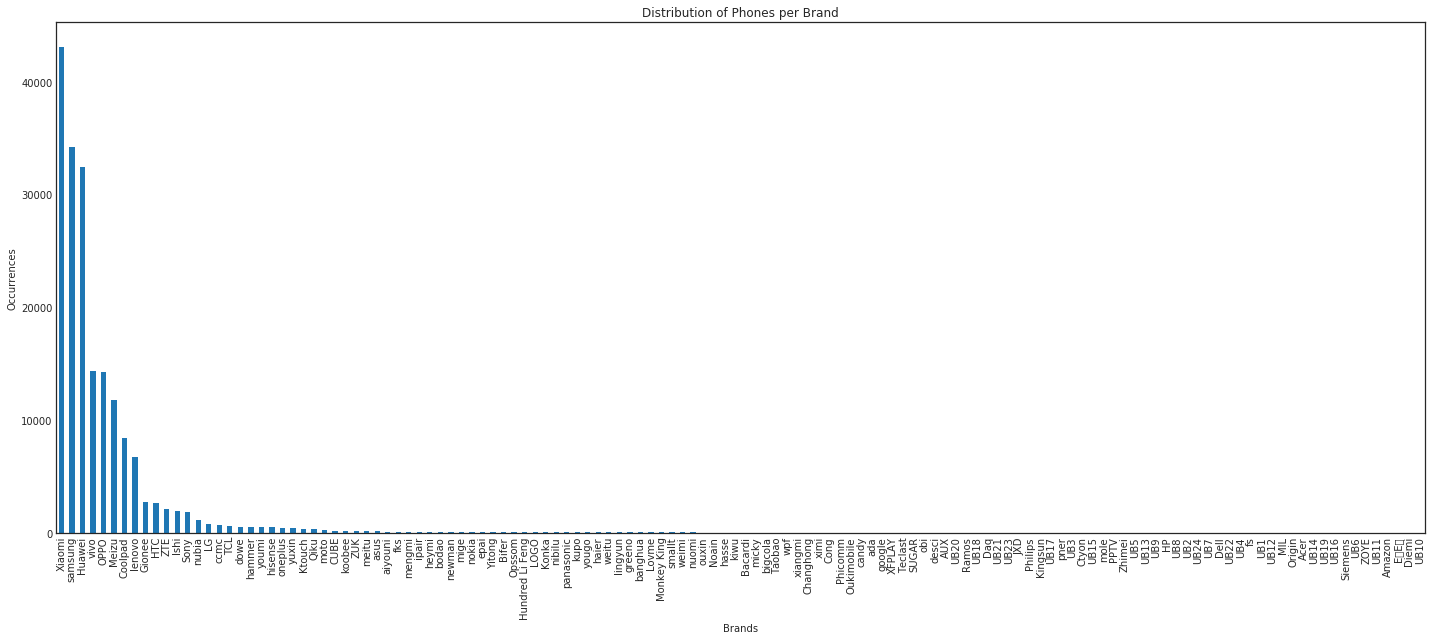

In [17]:
#Plot the distribution of brands by occurrence

plt.figure(figsize=(20, 9))
phone.phone_brand.value_counts().plot(kind='bar', grid=False)
plt.title('Distribution of Phones per Brand')
plt.xlabel('Brands')
plt.ylabel('Occurrences')
plt.tight_layout()
plt.show()

To avoid the dummy variable trap whereby collinearity exists between the variables one redundant category is dropped when transforming the categorical variables into dummies.

In [18]:
#Build the dummy variables with the phone brand
phone_dummies = pd.get_dummies(phone, columns = ['phone_brand'], sparse = True).reset_index(drop= True)

In [19]:
#Merge the demographic dataset with the phone dataset
final_dataset = (
    dataset_with_dummy_variables
    
     # Merge on event_id
    .merge(phone_dummies, how = 'left', left_on = 'device_id', right_on = 'device_id')
    
     # event_id itself is not interesting
    .fillna(0))

In [20]:
#Information about the dataset
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2314247 entries, 0 to 2314246
Columns: 620 entries, is_active to phone_brand_yuxin
dtypes: float64(1), int64(2), object(2), uint8(615)
memory usage: 1.4+ GB


The new dataset has been cleansed eliminating all the columns that are zeros. In this case, 345 columns have been deleted related to brands that were not associated to devices. The output variable that groups gender and age “group” has been transformed into numbers so that supervised algorithms are used for prediction.

In [21]:
#Drop from the final dataset duplicates for the devices keeping the first one
final_dataset = final_dataset.drop_duplicates('device_id',keep= 'first').reset_index(drop=True)

#Get infomation of the new dataset to see the rows that have been eliminated
print(final_dataset.info())

#Print the first five rows of the dataset
final_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23290 entries, 0 to 23289
Columns: 620 entries, is_active to phone_brand_yuxin
dtypes: float64(1), int64(2), object(2), uint8(615)
memory usage: 14.5+ MB
None


,is_active,device_id,gender,age,group,label_id_2,label_id_4,label_id_6,label_id_7,label_id_8,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,1,1476664663289716375,M,19.0,M22-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,7166563712658305181,M,60.0,M39+,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,-3449419341168524142,M,28.0,M27-28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,-6542093539413689868,M,26.0,M23-26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,-5638521260975573107,M,22.0,M22-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The gender split in the data is not even, being more male than women in the customer base of the company. This has an impact in the further segmentation by age (including gender) expecting groups that have a lower number of data points in the case it is for women. A visual inspection of the groups show that the groups are unbalanced. This will impact the accuracy of the models for classification purposes. Further resampling is required and in this case, up-sampling will be considered using the number of samples in the largest group: males between 32 and 38 years (3338 samples).

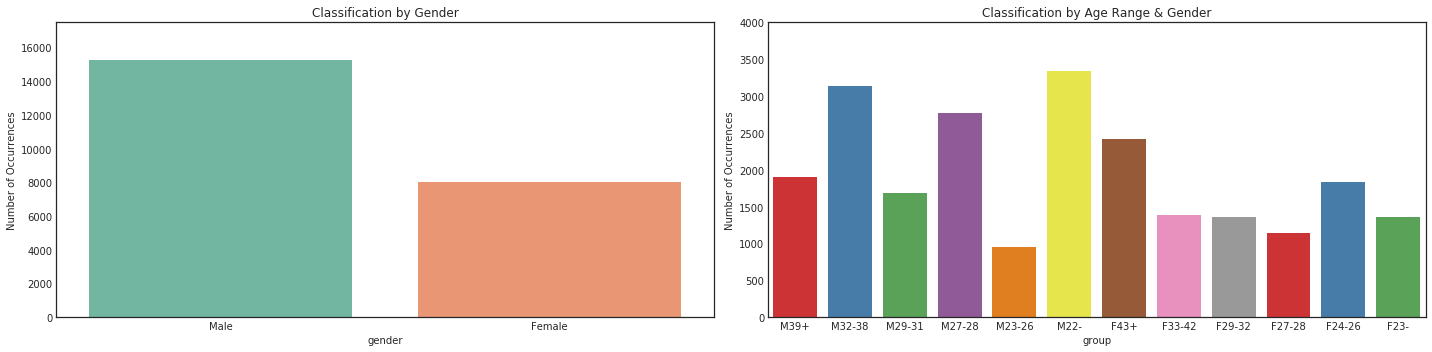

M32-38    3338
M39+      3137
M23-26    2770
M29-31    2423
M22-      1901
F33-42    1832
M27-28    1682
F29-32    1387
F23-      1365
F43+      1357
F24-26    1140
F27-28     958
Name: group, dtype: int64


In [22]:
#Visualize the number of answers by Gender and by Category
#Check the outcome variable and see if there is any imbalance

plt.figure(figsize=(20, 5))
sns.set_style("white")

plt.subplot(1, 2, 1)
ax = sns.countplot(x="gender", data=final_dataset, palette="Set2")
ax.set_title('Classification by Gender')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(['Male','Female'], fontsize=10)
plt.ylim(0, 17500)

plt.subplot(1, 2, 2)
ax = sns.countplot(x="group", data=final_dataset, palette="Set1")
ax.set_title('Classification by Age Range & Gender')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(['M39+','M32-38', 'M29-31', 'M27-28', 'M23-26','M22-','F43+','F33-42', 'F29-32', 'F27-28', 'F24-26', 'F23-'], fontsize=10)
plt.ylim(0, 4000)

plt.tight_layout()
plt.show()

#Count number of datapoints for each group to resample all of them.
print(final_dataset['group'].value_counts())

As the different groups are not balanced, the minority groups are balanced resampling the data and up-sampling the minority groups. This will allow the different algorithms to achieve a better accuracy in general. Algorithms like random forest are highly sensitive to unbalanced groups in the output variable.

In [23]:
#Upsample minority classes
# Separate majority and minority classes
final_dataset_majority = final_dataset[final_dataset.group=='M32-38']

#Minorty classes
final_dataset_minority_1 = final_dataset[final_dataset.group=='M39+']
final_dataset_minority_2 = final_dataset[final_dataset.group=='M23-26']
final_dataset_minority_3 = final_dataset[final_dataset.group=='M29-31']
final_dataset_minority_4 = final_dataset[final_dataset.group=='M22-']
final_dataset_minority_5 = final_dataset[final_dataset.group=='F33-42']
final_dataset_minority_6 = final_dataset[final_dataset.group=='M27-28']
final_dataset_minority_7 = final_dataset[final_dataset.group=='F29-32']
final_dataset_minority_8 = final_dataset[final_dataset.group=='F23-']
final_dataset_minority_9 = final_dataset[final_dataset.group=='F43+']
final_dataset_minority_10 = final_dataset[final_dataset.group=='F24-26']
final_dataset_minority_11 = final_dataset[final_dataset.group=='F27-28']

 
# Upsample airlines minorities
final_dataset_upsampled_1 = resample(final_dataset_minority_1, replace=True, n_samples=3338, random_state=123) 
final_dataset_upsampled_2 = resample(final_dataset_minority_2, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_3 = resample(final_dataset_minority_3, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_4 = resample(final_dataset_minority_4, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_5 = resample(final_dataset_minority_5, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_6 = resample(final_dataset_minority_6, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_7 = resample(final_dataset_minority_7, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_8 = resample(final_dataset_minority_8, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_9 = resample(final_dataset_minority_9, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_10 = resample(final_dataset_minority_10, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_11 = resample(final_dataset_minority_11, replace=True, n_samples=3338, random_state=123)
     
# Combine majority class with upsampled minority classes
final_dataset_upsampled = pd.concat([final_dataset_majority, final_dataset_upsampled_1, final_dataset_upsampled_2,
                                  final_dataset_upsampled_3, final_dataset_upsampled_4, final_dataset_upsampled_5,
                                  final_dataset_upsampled_6, final_dataset_upsampled_7, final_dataset_upsampled_8,
                                  final_dataset_upsampled_9, final_dataset_upsampled_10, final_dataset_upsampled_11])
# Display new class counts
final_dataset_upsampled.group.value_counts()

F29-32    3338
M39+      3338
M27-28    3338
M22-      3338
M32-38    3338
M29-31    3338
F27-28    3338
F23-      3338
M23-26    3338
F43+      3338
F24-26    3338
F33-42    3338
Name: group, dtype: int64

As part of the data cleansing actions, the device id column has been dropped and dummy variables have been created for the gender variable additionally all those columns that are constant and filled in only with zeros have been dropped. To avoid the dummy variable trap whereby collinearity exists between the variables one redundant category is dropped when transforming the categorical variables into dummies. The different groups have been mapped to 0-11 to be used in further modelling. In this case although different trials have taken place, after improving the significance of the features the twelve groups for the classification problem have been kept.

In [24]:
#Get dummy variables for the gender variable and reset index
clean_final_dataset = pd.get_dummies(final_dataset_upsampled, columns = ['gender'], sparse = True,).reset_index(drop= True)

#Delete column with device_id
clean_final_dataset = clean_final_dataset.drop('device_id', axis = 1)

#Delete columns that are all zeros
clean_final_dataset = clean_final_dataset.drop(clean_final_dataset.columns[(clean_final_dataset == 0).all()], axis = 1)

#Substitute the categorical output variable 
clean_final_dataset['group'] = clean_final_dataset['group'].map({'M39+' :0,'M32-38':1, 'M29-31':2, 'M27-28':3, 'M23-26':4,'M22-': 5,
                                           'F43+' :6,'F33-42':7, 'F29-32':8, 'F27-28':9, 'F24-26':10, 'F23-':11 })

#Print the first five rows of the new dataset
clean_final_dataset.head()

,is_active,age,group,label_id_6,label_id_8,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,...,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin,gender_F,gender_M
0,1,35.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,34.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,36.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,35.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,33.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


As it can be appreciated the average age of the users is 31 years with a standard deviation of nearly 10 years. The interquartile age is between 26 and 37 years. For each of the labels and brands it can be seen that all the ones included appear at least once as it was expected from the data wrangling actions. Although group appears in the table, the results obtained means that the group M23-26 grouping male between 23 and 26 is the most significant one in terms of appearance.  

In [25]:
#Describe the data using statistics
clean_final_dataset.describe()

,is_active,age,group,label_id_6,label_id_8,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,...,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin,gender_F,gender_M
count,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,...,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000,40056.000000
mean,0.510685,31.315234,5.500000,0.000100,0.000524,0.000025,0.001273,0.000125,0.000699,0.000125,...,0.000175,0.000250,0.000075,0.000025,0.000050,0.000125,0.000300,0.001373,0.500000,0.500000
std,0.499892,9.830269,3.452096,0.009993,0.022891,0.004997,0.035660,0.011172,0.026430,0.011172,...,0.013219,0.015799,0.008654,0.004997,0.007066,0.011172,0.017306,0.037030,0.500006,0.500006
min,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,25.000000,2.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,28.500000,5.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
75%,1.000000,35.000000,8.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,86.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The dataset has been split between the predictors and the output variable. As abovementioned, the output variable is the group of age and gender and the input variables are the features created based on the app labels, gender and phone brand used by the users. To improve the quality of the features the data has been preprocessed and scaled.

In [26]:
#Build the predictors and output variables
X = clean_final_dataset.drop('group',axis = 1)
y = clean_final_dataset.group

#Preprocess and scale data
names = X.columns
X_processed = pd.DataFrame(normalize(preprocessing.scale(X)), columns = names)

The size of the final dataset is 274 variables and 40k rows of data from which features will be generated.

In [27]:
#Check shape of X_processed and y
print(X_processed.shape, y.shape)

#Print the groups in y
print(y.unique())

(40056, 273) (40056,)
[ 1  0  4  2  5  7  3  8 11  6 10  9]


To have a better understanding of the correlation between variables, and due to the large amount of variables in this dataset, a correlation matrix has been created. To check the level of correlation between variables, only those with a correlation greater than 0.5 and lower than 1 (in absolute terms) have been printed.

In [28]:
#Build the correlation matrix between scores
correlation_mat = X_processed.corr()

#Check the correlation between values
corr_values = correlation_mat.unstack()
corr_values_sorted = corr_values.sort_values(kind="quicksort", ascending=False)

#Check high postivie correlations (between 0.4 and 1)
print(('Values presenting correlation between 0.4 and 1 (excluding 1) \n\n {}:')
      .format(corr_values_sorted[corr_values_sorted.between(0.4, 0.99, inclusive=True)]))

#Check high negative correlations (between -0.4 and -1)
print(('Values presenting correlation between -0.4 and -1 (excluding -1) \n\n {}:')
      .format(corr_values_sorted[corr_values_sorted.between(-0.4, -0.99, inclusive=True)]))

Values presenting correlation between 0.4 and 1 (excluding 1) 

 label_id_706      phone_brand_OPPO    0.420881
phone_brand_OPPO  label_id_706        0.420881
dtype: float64:
Values presenting correlation between -0.4 and -1 (excluding -1) 

 Series([], dtype: float64):


As it can be observed only the pone brand "OPPO" and the app label 706 present the highest correlation equal to 0.42. Further inspection shows that this brand includes a "customized" app in all the phones to access special features. As expected there is no negative correlation higher than 0.4 (in absolute terms) due to the characteristics of the data. There are no apps that cannot be installed in certain phone brands or that decrease when the number of phones of that brand increases.

The dataset has been split into predictors and target variable and the dataset split into a train and test data set (70/30) defining five folds for cross validation. This train test split will be used for the feature generation steps and as part of the unsupervised exploratory data analysis.

In [29]:
#Split the dataset into a training and testing dataset 70/30
X_train, X_test, y_train, y_test = train_test_split(X_processed, y,test_size=0.3, random_state=42)

### 3. Feature Generation ###

The feature selection process will start with a PCA analysis to understand the number of features required to describe more than 90% of the variance of the outcome variable. Once the number of features is identified, the following methods will be used to select the features that will be used to run build the binary classifier:

1. Feature Importance using Random Forest
2. Feature Selection using kbest()

The features obtained by each of the methods will be compared to see if the selected ones are stable and the final number of features will be determined by the number of features obtained from PCA. The number of features is determined from the results obtained from PCA analysis.

In [30]:
#Feature Selection. 
#Scores for the most relevant features (should we start with the one that has more explanatory power)

#Feature extraction. Starting and fitting the model
test = SelectKBest()
fit = test.fit(X_processed, y)

#Identify features with highest score from a predictive perspective (for all programs)
names = X_processed.columns

#Put the features and scores into a dataframe.
best_features = pd.DataFrame(fit.scores_, index = names).reset_index()
best_features.columns = ['Best Features', 'Scores']

#Show the features in descending order from those that have more explanatory power to the ones that have less.
best_features.sort_values(by=['Scores'], ascending=False)

,Best Features,Scores
272,gender_M,16659.586692
271,gender_F,16659.586692
1,age,12557.935109
196,phone_brand_Huawei,44.932644
262,phone_brand_vivo,43.898505
205,phone_brand_OPPO,43.211478
202,phone_brand_Meizu,39.752726
122,label_id_706,32.156860
102,label_id_262,27.021782
181,label_id_1012,22.089015


Due to the characteristics of the variables the use of all the features create a lot of noise and when the supervised models are run, there is overfitting in all cases. Hence, the number of variables is reduced using Kbest using only those that have an explanatory power higher than 1. A dataframe is created with this new set of features.

In [31]:
#Select all the features that have an explanatory power higher than 1.
list_of_best_features = best_features.loc[best_features['Scores'] > 1]['Best Features'].tolist()

#Create a dataframe with the new features
columns = list_of_best_features
X_best_features = pd.DataFrame(X_processed, columns = columns).reset_index(drop= True)

#Print information of the dataset
X_best_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40056 entries, 0 to 40055
Columns: 266 entries, is_active to gender_M
dtypes: float64(266)
memory usage: 81.3 MB


To select the features, Feature Importance using Random Forest is used. In this case the result given by the random forest feature selection is not meaningful therefore the result given by kbest() will be used as a first step before running PCA for generating the new set of features. From the random forest feature selection it can be observed that the number of features has to be reduced significantly as there are a lot of features that are adding noise and with low explanatory power.

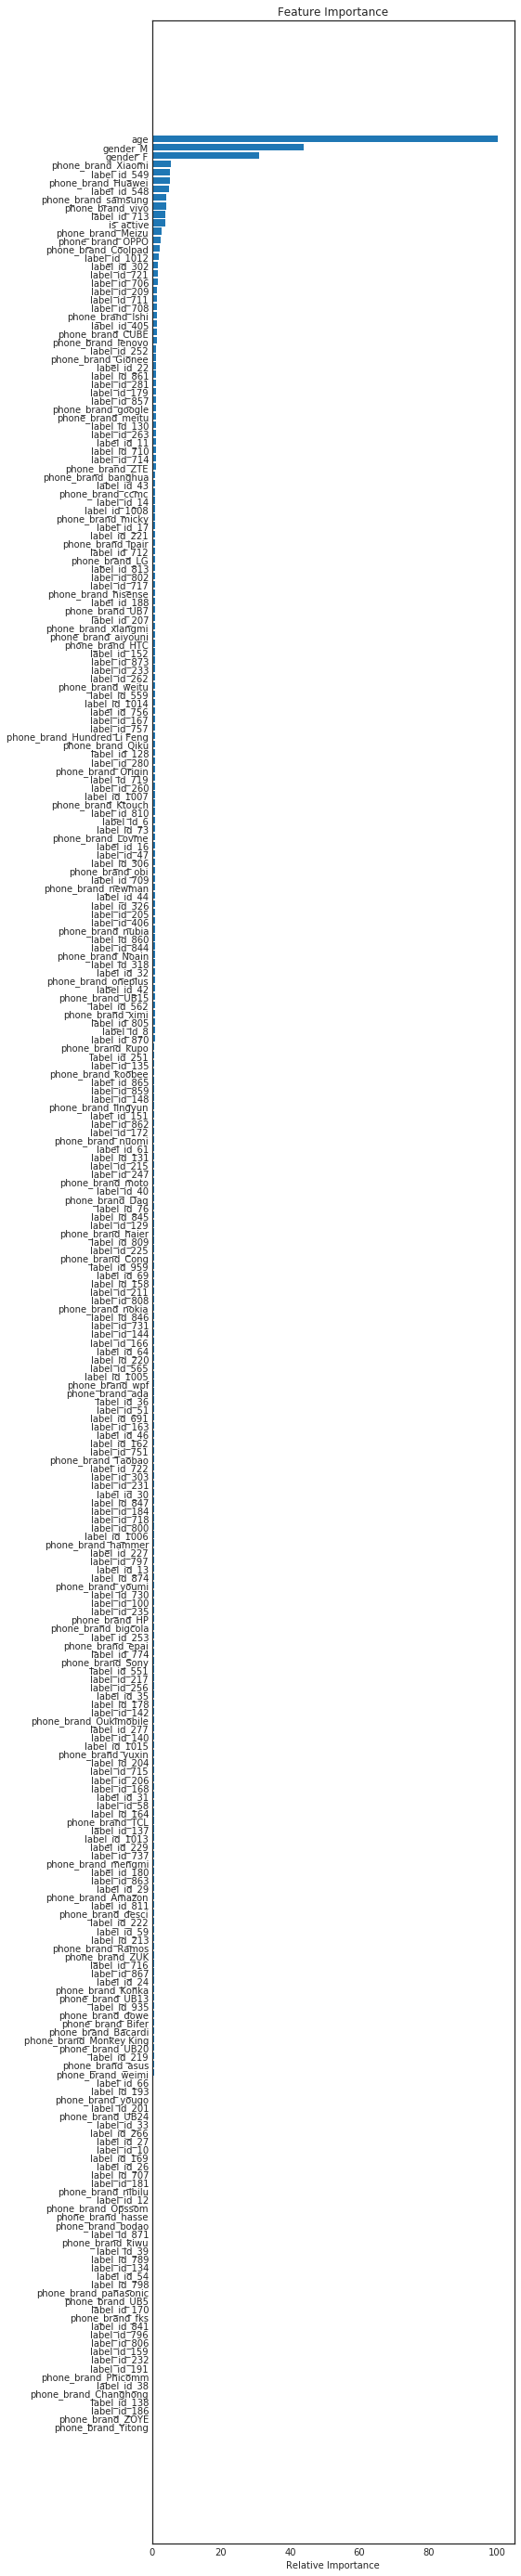

In [33]:
#Start the Random Forest Classifier
rf = RandomForestClassifier()
rf.fit(X_processed, y)

#Define feature importance
feature_importance = rf.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot the features importance
plt.figure(figsize=(7, 50))
plt.subplot(1, 1, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_processed.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show()

The feature selection using Radnom forest shows the high contribution of age, gender and certain brands over the apps ids. It cn be seen that all of them have a contribution and after running iteratively on the 16 best features selected by Random Forest the accuracy obtained with Logistic Regression was very low. Once features from kbest were added to the feature space accuracy results improved. Hence the features obtained using kbest() will be the ones that will be transformed using PCA. As a second step, the variables selected by Kbest are transformed using PCA analysis. For this, the correlation matrix of the new set of variables is created and non existing values are filled in with zeros.

In [34]:
# Assign the value to a new variable
corr_variable = X_best_features

#Build the correlation matrix
correlation_matrix = corr_variable.corr()

#Clean the correlation matrix adding zeros to the cells that are non existent
correlation_matrix = correlation_matrix.fillna(0)

Calculate the eigen-values and vectors and determine the explained variance by each component.

In [35]:
#Eigenvectores & Eigenvalues

eig_vals, eig_vecs = np.linalg.eig(correlation_matrix)

sklearn_pca = PCA(n_components=len(corr_variable.columns))
Y_sklearn = sklearn_pca.fit_transform(correlation_matrix)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [  1.90514054e-02   1.55622558e-02   1.12389228e-02   8.25626753e-03
   7.41225121e-03   5.85913861e-03   5.51009685e-03   5.32309609e-03
   5.21588311e-03   4.98022742e-03   4.95615242e-03   4.75856600e-03
   4.70017697e-03   4.41290418e-03   4.34361212e-03   4.26294298e-03
   4.17834662e-03   4.15833273e-03   4.10373513e-03   4.06674603e-03
   4.05297378e-03   4.04383800e-03   4.03789539e-03   4.00488570e-03
   3.99593810e-03   3.97292008e-03   3.96432993e-03   3.92449081e-03
   3.91023523e-03   3.88998124e-03   3.88578393e-03   3.87554065e-03
   3.86559654e-03   3.86015146e-03   3.84184066e-03   3.82322286e-03
   3.80290908e-03   3.79925678e-03   3.79027035e-03   3.76965543e-03
   3.74887503e-03   3.73473881e-03   3.73424267e-03   3.73356754e-03
   3.71871549e-03   3.71751204e-03   3.71055534e-03   3.70017927e-03
   3.69377894e-03   3.67953523e-03   3.67363068e-03   3.67111240e-03
   3.671

From the PCA analysis abovementioned the PCA features are created. After analysing the feature generation using recursive feature analysis and feature selection using kbest(), the PCA features will be used. Additionally, there is no need to have the initial features as predictors or now which ones have been used as the main purpose of the classification process is to maximize the accuracy.

In [36]:
#PCA features

# Create a scaler object
sc = StandardScaler()

# Fit the scaler to the features and transform
X_std = X_best_features 

# Create a PCA object from Scree plot the number of components is 120
pca = decomposition.PCA(n_components=120)

# Fit the PCA and transform the data
X_std_pca = pca.fit_transform(X_std)

# View the new feature data's shape
X_std_pca.shape

# Create a new dataframe with the new features
X_pca = pd.DataFrame(X_std_pca)

#Check the shape of the dataframe containing the PCA components
X_pca.shape

(40056, 120)

### 4. Model Selection ###

The dataset is split 70/30 train test and several models will be tuned in the training set and run on the test set calculating their accuracy using cross validation. The purpose of this is to train and test the classification models avoiding overfitting, exposing the algorithms to unknown data in the test set. The cross validation will be done using five folds, in this case and as data has been resampled the representation of each class is even across folds avoiding the need to stratify the data, although its use would reduce the bias and variance effects if classes were not evenly distributed in the dataset.

In [37]:
#Split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

#KFold for cross validation analysis
kf = KFold(5)

All models' hyperparameters will be tuned in the training set using cross validation and gridsearch tuning several parameters considered in the pipeline (gridsearch). Except for specific cases that will be discussed one by one, the algorithm or variations (solver, etc) to be used has been decided in advance considering the topology of the dataset.
The models that have been selected to be tested on the dataset to accurately classify the data are:

4.1 Logistic Regression

4.2 Naïve - Bayes (Bernoulli)

4.3. KNeighbors Classifier

4.4 Random Forest

4.5 Support Vector Machine

4.6 Gradient Boosting Classifier

4.7 Linear Support Vector Machine

All classes have been transformed from their original categorical tag to values from 0 to 11 to enable classification. In this case there is no bias towards a type I or type II misclassification error in terms of cost. There is no "negative or positive" case as if one of the groups of users is misclassified, then the marketing effort will be inefficient. Hence, both errors have the same weight and the overall accuracy will be used as hyperparameter tuning score and as an indicator of overall final accuracy. The time required to fit the model and run the cross validation using five folds will be used to indicate the computational effort of each model.

#### 4.1 Logistic Regression ####

The first model to be run is the Logistic Regression model. The following hyperparameters of the model have been tuned using searchgridCV and the overall accuracy as the selection strategy:

1.	Parameter "C" will be tuned in the training set. Lower values of C parameter will show a higher regularization.

The model is initialized and several values are tested. Lower values of parameter "C" will give a stronger regularization of the model. The solver is set to "lbfgs" as it provides a similar accuracy than "liblinear" reducing the computational effort considerably (from 45 min to 3.3 min) being adequate for the problem and size of the dataset.

In [41]:
# Initialize and fit the model.
log_reg = LogisticRegression(class_weight='balanced', multi_class= 'multinomial', solver = 'lbfgs', max_iter = 1500)

#Tune parameters: C parameter
c_param = [100, 200, 1000]

parameters = {'C': c_param}

#Fit parameters
log_reg_tuned = GridSearchCV(log_reg, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
log_reg_tuned.fit(X_train, y_train)

#Print the best parameters
print(('Best paramenters logistic regression:\n {}\n').format(log_reg_tuned.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  6.9min finished


Best paramenters logistic regression:
 {'C': 1000}



The tuned model is fit and run on the test set and the computational effort is measured considering the time required to fit the test set.

In [42]:
#Once the model has been trained test it on the test dataset
log_reg_tuned.fit(X_test, y_test)

# Predict on test set
predtest_y = log_reg_tuned.predict(X_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.3min finished


The model requires 3.3 min to run which will be used as a time threshold to measure the computational effort of other models. To calculate the accuracy the model is evaluated on the test set. From the classification report it can be seen that the data representing each class is evenly distributed across the classes. This reduces the probability of bias of the model when calculating the probabilities of each predicted value.

In [43]:
#Evaluation of the model (testing)

#Define the Target values
target_names = ['0.0', '1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','10.0','11,0']

#Print the Classification Report
print(('Classification Report: \n {}').format(classification_report(y_test, predtest_y, target_names=target_names)))

#Calculate the confusion matrix
confusion_lr = confusion_matrix(y_test, predtest_y)

#Print the Confusion Matrix
print(('Confusion Matrix: \n\n {}\n').format(confusion_lr))

#Print the overall accuracy per class
print(('Logistic Regression set accuracy: {0:.2f} % \n').format(cross_val_score(log_reg_tuned, X_test,
                                                                                      y_test,cv=kf).mean()*100))

Classification Report: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      1017
        1.0       1.00      1.00      1.00      1036
        2.0       1.00      1.00      1.00       973
        3.0       1.00      1.00      1.00       994
        4.0       1.00      1.00      1.00      1015
        5.0       1.00      1.00      1.00       991
        6.0       1.00      1.00      1.00       991
        7.0       1.00      1.00      1.00       985
        8.0       1.00      1.00      1.00       980
        9.0       1.00      1.00      1.00       992
       10.0       1.00      1.00      1.00      1047
       11,0       1.00      1.00      1.00       996

avg / total       1.00      1.00      1.00     12017

Confusion Matrix: 

 [[1013    4    0    0    0    0    0    0    0    0    0    0]
 [   0 1035    1    0    0    0    0    0    0    0    0    0]
 [   0    0  973    0    0    0    0    0    0    0    0    0]
 [   0    0    0  99

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.8min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.7min finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.8min finished


Logistic Regression set accuracy: 95.62 % 



The overall accuracy of the Logistic Regression model is 95.62%. Although the overall accuracy is good and the computational effort low, the classification report and confusion matrix show overfitting as there will be some data points misclassified. The high accuracy of the model can be explained by the lack of correlation between the predictors (independent variables). Only two variables out of 120 presented a correlation of 0.5 (max correlation value in the dataset) which have been eliminated when during the feature generation process and through PCA. The PCA components are all independent from each other and by definition there is no collinearity between the 120 components that have been chosen. Additionally linearity between the independent variable and the log odds exists. Furthermore, the dataset is big enough to use this classification algorithm.

#### 4.2 Naive Bayes ####

From the Naïve Bayes models the Bernoulli algorithm has been implemented because Bernoulli model can be trained using less data and be less prone to overfitting. The hyperparameter to be tuned is "alpha".

In [62]:
# Initialize and fit the model.
naive_bayes_bernoulli= BernoulliNB()

#Tune hyperparameters
#Create range of values to fit parameters
alpha = [10, 100, 200, 1000]
parameters = {'alpha': alpha}

#Fit parameters using gridsearch
naive_bayes_bernoulli_tuned = GridSearchCV(naive_bayes_bernoulli, n_jobs = -1, param_grid=parameters, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
naive_bayes_bernoulli_tuned.fit(X_train, y_train)

#Print the best parameters
print(('Best paramenters logistic Naive-Bayes Bernoulli: \n{}\n').format(naive_bayes_bernoulli_tuned.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.5s finished


Best paramenters logistic Naive-Bayes Bernoulli: 
{'alpha': 10}



The value for "alpha" is the smallest of the values chosen to tune the parameters of the model. In this case the gridsearch has been carried out with values ranging from 0.001 to 10 before fitting the above set. In all cases, 10 was the value that was appearing as the best one in terms of overall accuracy. The tuned model is fit and run on the test set and the computational effort is measured considering the time required to fit the test set.

In [63]:
#Once the model has been trained test it on the test dataset
naive_bayes_bernoulli_tuned.fit(X_test, y_test)

# Predict on test set
predtest_y = naive_bayes_bernoulli_tuned.predict(X_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.5s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.5s finished


Once the algorithm is trained it is run on the test set. The maximum precision obtained is 70% for the first class being all of the rest lower than 50%. From an accuracy perspective this algorithm doesn't seem to be a good candidate for our product. Cross validation has been performed to avoid overfitting:

In [64]:
#Evaluation of the model (testing)

#Define the Target values
target_names = ['0.0', '1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','10.0','11,0']

#Print the Classification Report
print(('Classification Report: \n {}').format(classification_report(y_test, predtest_y, target_names=target_names)))

#Calculate the Confusion Matrix
confusion_ber = confusion_matrix(y_test, predtest_y)

#Print the Confusion Matrix
print(('Confusion Matrix: \n\n {}\n').format(confusion_ber))

#Print the overall accuracy
print(('Bernoulli Classifier set accuracy: {0:.2f} % \n').format(cross_val_score(naive_bayes_bernoulli_tuned,
                                                                                               X_test,
                                                                                               y_test,
                                                                                               cv=kf).mean()*100))

Classification Report: 
              precision    recall  f1-score   support

        0.0       0.70      0.70      0.70      1017
        1.0       0.41      0.47      0.44      1036
        2.0       0.29      0.21      0.24       973
        3.0       0.27      0.26      0.27       994
        4.0       0.26      0.28      0.27      1015
        5.0       0.47      0.49      0.48       991
        6.0       0.78      0.73      0.75       991
        7.0       0.38      0.51      0.44       985
        8.0       0.26      0.20      0.22       980
        9.0       0.28      0.22      0.25       992
       10.0       0.34      0.33      0.33      1047
       11,0       0.41      0.51      0.45       996

avg / total       0.41      0.41      0.41     12017

Confusion Matrix: 

 [[713 187  36  27  42   8   0   4   0   0   0   0]
 [187 490  96 116 113  27   0   4   3   0   0   0]
 [ 65 220 201 179 224  81   0   3   0   0   0   0]
 [ 28 147 135 261 245 172   0   3   1   0   2   0]
 [ 25

[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.4s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.4s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.4s remaining:    1.2s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.4s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.3s finished


Bernoulli Classifier set accuracy: 37.93 % 



In this case the low accuracy of the Naïve-Bayes classifier can be explained because of the continuous structure of the data once the scaler and PCA has been applied. Although the features are strongly independent due to the PCA transformation of them, this classifier is good when it is used for binary problems with two classes. In this case, the existence of 12 different classes makes it harder for this algorithm to classify accurately.

#### 4.3 K-nearest neighbors ####

A K-Neighbors model has been implemented and tuned on the train set. The parameters tuned are:

1. Number of neighbors which will determine the number of points used to classify into each of the categories the data points
2. Two weighting systems to be tested: uniform and distance.
3. The number of neighbors when tuning the model has been capped to 11

In [77]:
#Train model
# Initialize and fit the model.
KNN = KNeighborsClassifier()

#Tune hyperparameters
#Create range of values to fit parameters
neighbors = [5, 7,9, 11]
weights = ['uniform', 'distance']

#Fit parameters
parameters = {'n_neighbors': neighbors, 'weights': weights}

#Fit parameters using gridsearch
KNN_tuned = GridSearchCV(KNN, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
KNN_tuned.fit(X_train, y_train)

#Print the best parameters
print(('Best paramenters KNN:\n {}\n').format(
KNN_tuned.best_params_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  3.5min finished


Best paramenters KNN:
 {'n_neighbors': 5, 'weights': 'distance'}



The value for "n_neighbors" is the smallest of the values chosen to tune the parameters of the model. In this case the gridsearch has been carried out with values ranging from 3 to 11, always odd as the number of classes is even before fitting the above set. In all cases, 5 was the value that was appearing as the best one in terms of overall accuracy. The algorithm to be used has been set to "auto" and the algorithm used is "brute force" in this case as k < n_samples/2 and no specific metrics have been given. In this case the leaf size has been set to the default value of 30 considering the number of features used. The choice fo distance as the weight instead of uniform is reasonable were the points are weighted by the inverse of their distance. In this case features are different from each other ranging from different types of apps to device brands. The tuned model is fit and run on the test set and the computational effort is measured considering the time required to fit the test set.

In [78]:
#Once the model has been trained test it on the test dataset
KNN_tuned.fit(X_test, y_test)

# Predict on test set
predtest_y = KNN_tuned.predict(X_test)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.5min finished


In this case, due to the characteristics of the algorithm (lazy algorithm) all the work is done in the previous step as the prediction is required. This algorithm goes through all the dataset comparing each data point with the instances that it has previously seen while it was trained. This could be the reason why this step requires some more time than the previous and next ones (1.1 min per fold).
From the requirements to achieve good accuracy only two out of the three have been fulfilled, hence not a very high accuracy is expected. Data has been scaled and missing values have been addressed but the dimensionality of the problem is very large. In this case the dimensionality is 120 and the Euclidean distance does not perform well with high dimensions as points that may be similar may have very large distances.
As it can be seen the confusion matrix and the classification report are not adding value from an information perspective as it appears to have no misclassification. In this case, there is overfitting that is corrected through cross validation:

In [79]:
#Evaluation of the model (testing)

#Define targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print classification report
print(('Classification Report KNN: \n {}\n').format(classification_report(y_test, predtest_y, target_names=target_names)))

#Calculate confusion matrix
confusion_knn = confusion_matrix(y_test, predtest_y)

#Print confusion matrix
print(('Confusion Matrix KNN: \n\n {}\n\n').format(confusion_knn))

#Print overall accuracy
print(('KNN accuracy: {0:.2f} %\n').format(cross_val_score(KNN_tuned, X_test, y_test,cv=kf).mean()*100))

Classification Report KNN: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      1017
        1.0       1.00      1.00      1.00      1036
        2.0       1.00      1.00      1.00       973
        3.0       1.00      1.00      1.00       994
        4.0       1.00      1.00      1.00      1015
        5.0       1.00      1.00      1.00       991
        6.0       1.00      1.00      1.00       991
        7.0       1.00      1.00      1.00       985
        8.0       1.00      1.00      1.00       980
        9.0       1.00      1.00      1.00       992
       10.0       1.00      1.00      1.00      1047
       11.0       1.00      1.00      1.00       996

avg / total       1.00      1.00      1.00     12017


Confusion Matrix KNN: 

 [[1017    0    0    0    0    0    0    0    0    0    0    0]
 [   0 1036    0    0    0    0    0    0    0    0    0    0]
 [   0    0  973    0    0    0    0    0    0    0    0    0]
 [   0    0

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.1min finished


Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.2min finished


KNN accuracy: 71.36 %



As it was expected the accuracy obtained for this problem with this algorithm is lower than the values that are normally obtained with lower dimensionalities. As previously discussed this has to do with the fact that the Euclidean distance doesn´t perform accurately with high dimensionality problems and that it is used to measure the weight of each vote through the inverse of its value.

#### 4.4 SGD Classifier ####

The SGD Classifier uses regularized linear models with stochastic gradient descendent learning. The model is updated in its learning rate after the gradient of the loss is estaimated for each sample. This classifier can work with sparse data as the one obtained from building up the features when working with categorical ones. In this case from the types of penalties the algorithm accepts, it uses L2 instead of a combination of L1 and L2 implemented through Elastic Net.

In [80]:
#Train model
# Initialize and fit the model.
SGD = SGDClassifier(class_weight = 'balanced', max_iter=1000)

#Tune hyperparameters
#Create range of values to fit parameters
loss_param = ['hinge', 'squared_hinge']
alpha_param = [0.0001, 0.001, 0.01, 0.1, 1]

#Fit parameters
parameters = {'loss': loss_param,'alpha': alpha_param}

#Fit parameters using gridsearch
SGD_tuned = GridSearchCV(SGD, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
SGD_tuned.fit(X_train, y_train)

#Print the best parameters
print(('Best paramenters SDG:\n {}\n').format(SGD_tuned.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 24.2min finished


Best paramenters SDG:
 {'alpha': 0.0001, 'loss': 'hinge'}



The parameters show that the smoothing continues to be loose as a first option as it is a regression with a gradient descendent algorithm. Regarding the loss, the hinge loss is used which means that the real loss, in case it is not convergent due to the sparse data used, is replaced by the upper bond forcing its convergence. Time required is significantly higher than with previous classifiers.

In [81]:
#Once the model has been trained test it on the test dataset
SGD_tuned.fit(X_test, y_test)

# Predict on test set
predtest_y = SGD_tuned.predict(X_test)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.5min finished


From a visual inspection of the classification report it can be observed how the lack of clear boundaries between data points is impacting the overall accuracy. Only in the case of group 6 the precision is over 90%, for the rest of them the maximum precision obtained is at a maximum of 60%. This will show up when the results are cross validated giving low accuracies.

In [82]:
#Evaluation of the model (testing)

#Define the Target values
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print the Classification report
print(('Classification Report: \n {}\n').format(classification_report(y_test, predtest_y,target_names=target_names)))

#Calculate the confusion Matrix
confusion_sgd = confusion_matrix(y_test, predtest_y)

#Print the Confusion Matrix
print(('Confusion Matrix: \n\n {}\n\n').format(confusion_sgd))

#Print the SGD overall accuracy
print(('SGD accuracy: {0:.2f} %\n').format(cross_val_score(SGD_tuned, X_test, y_test,cv=kf).mean()*100))

Classification Report: 
              precision    recall  f1-score   support

        0.0       0.60      0.91      0.73      1017
        1.0       0.27      0.21      0.24      1036
        2.0       0.39      0.31      0.34       973
        3.0       0.37      0.21      0.27       994
        4.0       0.24      0.19      0.21      1015
        5.0       0.61      0.96      0.75       991
        6.0       0.91      0.98      0.95       991
        7.0       0.46      0.40      0.43       985
        8.0       0.40      0.24      0.31       980
        9.0       0.38      0.31      0.34       992
       10.0       0.23      0.22      0.23      1047
       11.0       0.57      0.96      0.72       996

avg / total       0.45      0.49      0.46     12017


Confusion Matrix: 

 [[926   7  44  20  17   1   0   0   0   0   2   0]
 [494 220 134  93  79  14   0   1   1   0   0   0]
 [ 73 267 300 126 191  11   0   0   2   0   2   1]
 [ 22 228 207 207 305  25   0   0   0   0   0   0]
 [ 1

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.4min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.0min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.1min finished


SGD accuracy: 47.88 %



As the features describing each group are scattered not having clear boundaries between each group, the result obtained from the SGD algorithm is low and it is not expected to grow with a higher number of iterations. In this case and using square hinge the decision boundary will not be able to improve the misclassification of the different points. In any case, the accuracy is too low to be used 47.88%. Although the SGD solves the same classification problems than the logistic regression and can be more efficient in this case the improvement from a computing effort perspective does not compensate the low results obtained by the classifier.

#### 4.5 Random Forest ####

The hyperparamters of the random forest model will be tuned. The parameters to be tuned are (in the same order as the hyperparameter tuning has been performed):

1. N_estimators determining the number of trees that will be part of the algorithm.
2. Max depth determining the size of the tree.

In [83]:
# Initialize and fit the model.
rf = RandomForestClassifier()

#Tune hyperparameters
#Create range of values to fit parameters
n_estimators_param = np.arange(50,191,10)
max_depth_param = np.arange(1,40,5)

#Fit parameters
parameters = {'n_estimators': n_estimators_param, 'max_depth': max_depth_param}

#Fit parameters using gridsearch
rf_tuned = GridSearchCV(rf, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
rf_tuned.fit(X_train, y_train)

#Print the best parameters
print(('Best paramenters Random Forest:\n {}\n').format(rf_tuned.best_params_))

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 39.3min finished


Best paramenters Random Forest:
 {'max_depth': 31, 'n_estimators': 170}



The number of trees used is 170 being the depth of each tree 31. After several simulations, the parameters have stayed stable around these values. The random forest algorithm is an ensemble algorithm that works bringing together different decision trees and being more powerful than an individual decision tree. In this case it introduces randomness because it choses from a random sample of features the one that is decreasing how often a randomly chosen element will be incorrectly labelled using gini criterion. The high number of estimators ensure the accuracy of the model while it increases the computational effort required. In this case, it is important to have the classes balanced as in one of the 31 nodes it could happen that one of the minority classes disappear. From the random forest feature selection only "is active", "gender" and "age" add have significant explanatory power being the rest of the features noise to the model. The noise has been reduced by reducing the number ofo features and applying PCA to the model to gain in the explanatory power of the variance. The number of trees in the random forest classifier decreases the risk of overfitting while the number of nodes "depth" reduces the samples available and features available in each sample which can increase the risk of misclassification reducing the overall accuracy. Moreover "deep" trees can compensate the lower risk of overfitting by increasing the number of trees as it increases the probability of overfitting overall.

Once the parameters are tuned, the model is fit and run on the test set. As it can be seen from the hyperparameter tuning, the model requires much more time (computational effort) than the previous models. The increase in accuracy must justify the significant increase of time required to fit the model.

In [62]:
#Once the model has been trained test it on the test dataset
rf_tuned.fit(X_test, y_test)

# Predict on test set
predtest_y = rf_tuned.predict(X_test)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:  7.3min finished


There is a significant increase in the computational effort required by this algorithm as it was expected. The classification report and the classification matrix present overfitting as the precision in all cases is one and there are no misclassified elements. To avoid this overfitting problem, cross validation has been performed on the random forest.

In [85]:
#Evaluation of the model (testing)

#Define the targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print the classification report
print(('Classification Report RF: \n {}\n').format(classification_report(y_test, predtest_y,target_names=target_names)))

#Calculate the confusion matrix
confusion_rf = confusion_matrix(y_test, predtest_y)

#Print the confusion matrix
print(('Confusion Matrix RF: \n\n {}\n\n').format(confusion_rf))

#Print the overall accuracy
print(('Random Forest accuracy RF: {0:.2f} %\n').format(cross_val_score(rf_tuned,
                                                                              X_test,
                                                                              y_test, cv=kf).mean()*100))

Classification Report RF: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      1017
        1.0       1.00      1.00      1.00      1036
        2.0       1.00      1.00      1.00       973
        3.0       1.00      1.00      1.00       994
        4.0       1.00      1.00      1.00      1015
        5.0       1.00      1.00      1.00       991
        6.0       1.00      1.00      1.00       991
        7.0       1.00      1.00      1.00       985
        8.0       1.00      1.00      1.00       980
        9.0       1.00      1.00      1.00       992
       10.0       1.00      1.00      1.00      1047
       11.0       1.00      1.00      1.00       996

avg / total       1.00      1.00      1.00     12017


Confusion Matrix RF: 

 [[1017    0    0    0    0    0    0    0    0    0    0    0]
 [   0 1036    0    0    0    0    0    0    0    0    0    0]
 [   0    0  973    0    0    0    0    0    0    0    0    0]
 [   0    0  

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 12.9min finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 12.9min finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 13.1min finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 13.2min finished


Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 13.1min finished


Random Forest accuracy RF: 81.04 %



In this case, the overall accuracy of the model is 81.04% which is somehow low for this type of algorithms. In this case and after running the random forest feature selection this might have happened due to the additional features that are increasing the noise instead of adding information to the algorithm based on this feature selection process. As there are only four, when run in a set of trees of 31 nodes, it can happen that none of them remains until the end misclassifying results based on the remaining features that the algorithm picks randomly.

#### 4.6 Linear Support Vector Machine ####

A linear support vector classifier has been set up and tuned on the training data and run on the test set. The hyperparameters that have been tuned are:

1. C parameter, acting on the margin hyperplane having a bigger margin when C is smaller. (The value of C will tell the SVM how much misclassification is to be avoided).
2. The loss parameter.

In this case the crammer singer algorithm is used to solve the multiclass classification problem. This algorithm optimizes the joint objective over all classes but it is not interesting from a production standpoint as it rarely leads to better accuracy and is more expensive to compute. Due to the size of the feature´s space the linear SVC has been used first instead of the SVC due to computational restrictions. If the accuracy is high enough then the SVC will be discarded, otherwise it will be tested.

In [48]:
# Initialize and fit the model.
LSVC = LinearSVC(multi_class = 'crammer_singer')

#Tune hyperparameters
#Create range of values to fit parameters

loss_param = ['hinge','squared_hinge']
C_param = [10, 100, 1000]

#Fit parameters
parameters = {'loss': loss_param, 'C': C_param}

#Fit parameters using gridsearch
LSVC_tuned = GridSearchCV(LSVC, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
LSVC_tuned.fit(X_train, y_train)

#Print the best parameters
print(('Best paramenters Linear SVC:\n {}\n').format(LSVC_tuned.best_params_))

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 52.0min finished


Best paramenters Linear SVC:
 {'C': 100, 'loss': 'hinge'}



Although the Linear SVC has been implemented as it is more scalable than the support vector classifier, the time required to fit the values compared to the other algorithms makes it a weak candidate to go into production. Compared to the logistic regression classifier there must be a significant increase so that this classifier worth it in terms of computational effort. C has been tuned to 100 to control the misclassification that is allowed by this classifier. The tradeoff between the values of this parameter is the bias-variance trade off. If the parameter is low the classifier will allow small numbers of misclassification having a low bias but allowing a high variance. In our case, the parameter is high which is better from a scaling perspective but might have a high amount of bias under fitting the data in the classification problem. Hinge loss has been selected as the loss function to calculate the weights of the misclassifications on the training data and apply them to the test data.

In [49]:
#Once the model has been trained test it on the test dataset
LSVC_tuned.fit(X_test, y_test)

# Predict on test set
predtest_y = LSVC_tuned.predict(X_test)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 19.9min finished


Although the computational effort required when fitting the dataset is lower than initially expected, the accuracy is higher than in the case of the random forest and very close to the logistic regression classifier. The classification report and the classification matrix present overfitting as the precision in all cases is one and there are no misclassified elements. To avoid this overfitting problem, cross validation has been performed on the random forest.

In [50]:
#Evaluation of the model (testing)

#Define the targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print the classification report
print(('Classification Report: \n {}\n').format(
    classification_report(y_test, predtest_y,
                          target_names=target_names)))

#Calculate the confusion matrix
confusion_svc = confusion_matrix(y_test, predtest_y)

#Print the confusion matrix
print((
    'Confusion Matrix: \n\n {}\n\n').format(confusion_svc))

#Print the overall accuracy
print((
    'Linear SVC accuracy: {0:.2f} %\n'
).format(cross_val_score(LSVC_tuned, X_test, y_test,cv=kf).mean()*100))

Classification Report: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       920
        1.0       1.00      1.00      1.00       952
        2.0       1.00      1.00      1.00       784
        3.0       1.00      1.00      1.00       527
        4.0       1.00      1.00      1.00       840
        5.0       1.00      1.00      1.00       603
        6.0       1.00      1.00      1.00       407
        7.0       1.00      1.00      1.00       533
        8.0       1.00      1.00      1.00       417
        9.0       1.00      1.00      1.00       283
       10.0       1.00      1.00      1.00       334
       11.0       1.00      1.00      1.00       387

avg / total       1.00      1.00      1.00      6987


Confusion Matrix: 

 [[919   1   0   0   0   0   0   0   0   0   0   0]
 [  0 952   0   0   0   0   0   0   0   0   0   0]
 [  0   0 784   0   0   0   0   0   0   0   0   0]
 [  0   0   0 527   0   0   0   0   0   0   0   0]
 [  

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 16.4min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.2min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.9min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.6min finished


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 15.8min finished


Linear SVC accuracy: 94.99 %



In this case the support vector classifier uses a linear kernel for the kernel trick and a sparse representation of data (aligned to the features that have been generated for this problem) reducing the amount of computing effort required. In this case, there is a need to create linear hyperplanes that is able to separate one class over the rest until the 12 have been classified. Due to the characteristics of the data (PCA components are used as features and are oriented to maximize the explanation of the variance across classes) added to the C parameter the accuracy of the Linear Support Vector Classifier is higher than expected requiring less computational effort than the initially foreseen.

#### 4.7 Gradient Boosting Classifier ####

The hyperparamters of the gradient boosting classifier that are tuned are the same than in the case of the random forest. The parameters to be tuned are (in the same order as the hyperparameter tuning has been performed):

1. N_estimators determining the number of trees that will be part of the algorithm.
2. Max depth determining the size of the tree.

In [63]:
# Train model
GBC = GradientBoostingClassifier()

#Tune hyperparameters
#Create range of values to fit parameters

n_estimators_param = np.arange(140,211,10)
max_depth_param = np.arange(30,71,10)

#Fit parameters
parameters = {'n_estimators': n_estimators_param, 'max_depth': max_depth_param}

#Fit parameters
GBC_tuned = GridSearchCV(GBC, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned model
GBC_tuned.fit(X_train, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", GBC_tuned.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 55.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 257.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 278.9min finished


Best Hyper Parameters: {'max_depth': 50, 'n_estimators': 190}


In this case, as it is a boosting model, the data is passed over and over again tuning the parameters every time the data is passed. This is the reason why compared to the random forest it requires so much time. The number of trees is higher than the number of trees used in random forest and the depth is nearly doubling the one previously calculated for the random forest. In this case the computational effort has grown exponentially compared to other classifiers so it is expected that the accuracy is much higher than in the case of the logistic regression classifier to be a candidate for production. In this case, as it is based on random forest a slight increase of its accuracy is expected, hence it will not be as high as the one achieved with the logistic regression for the same reasons that applied to the random forest.

Once the parameters are tuned, the model is fit and run on the test set.

In [64]:
#Fit on the test set
GBC_tuned.fit(X_test, y_test)

# Predict on test set

predtestgb_y = GBC_tuned.predict(X_test)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 83.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 90.2min finished


In this case, the algorithm uses the gradient descendent algorithm to follow the steepest path that reduces the loss. In each step the tree is fitted to predict a negative gradient. The friedman_mse parameter used by default calculates the step after the direction has been set. As in the case of Random Forest, this classifier presents overfitting in the classification report and confusion matrix. To reduce the overfitting cross validation is applied.

In [65]:
#Evaluation of the model (testing)

#Define the targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print the classification report
print(('Classification Report: \n {}\n').format(classification_report(y_test, predtestgb_y,target_names=target_names)))

#Calculate the confusion matrix
confusion_GBC = confusion_matrix(y_test, predtestgb_y)

#Print the confusion matrix
print(('Confusion Matrix: \n\n {}\n\n').format(confusion_GBC))

#Print the overall accuracy
print(( 'Gradient Boosting Classifier accuracy: {0:.2f} %\n').format(cross_val_score(GBC_tuned
                                                                                     , X_test, y_test,cv=kf).mean()*100))

Classification Report: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       920
        1.0       1.00      1.00      1.00       952
        2.0       1.00      1.00      1.00       784
        3.0       1.00      1.00      1.00       527
        4.0       1.00      1.00      1.00       840
        5.0       1.00      1.00      1.00       603
        6.0       1.00      1.00      1.00       407
        7.0       1.00      1.00      1.00       533
        8.0       1.00      1.00      1.00       417
        9.0       1.00      1.00      1.00       283
       10.0       1.00      1.00      1.00       334
       11.0       1.00      1.00      1.00       387

avg / total       1.00      1.00      1.00      6987


Confusion Matrix: 

 [[920   0   0   0   0   0   0   0   0   0   0   0]
 [  0 952   0   0   0   0   0   0   0   0   0   0]
 [  0   0 784   0   0   0   0   0   0   0   0   0]
 [  0   0   0 527   0   0   0   0   0   0   0   0]
 [  

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 61.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 66.0min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 57.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 62.2min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 58.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 63.2min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 56.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 60.3min finished


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 55.7min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 60.1min finished


Gradient Boosting Classifier accuracy: 79.25 %



The gradient boosting algorithm has a similar approach to the random forest in the classification of the classes. In this case the depth of the trees is bigger and the number of trees also. The number of trees helps to reduce the overfitting while the depth has a negative effect in the misclassification reducing the accuracy. The same principle regarding the feature selection applies than in the case of random forest so it is not strange to find in this case an overall accuracy close to the one obtained with random forest. In the implementation of the descendent gradient over the random forest algorithm has not significantly improved the accuracy while it has increased the computational effort required to achieve it. Hence, this algorithm is discarded for production.

#### 4.8 Support Vector Classifier ####

A support vector classifier has been set up and tuned on the training data and run on the test set. The hyperparameters that have been tuned are:

1. C parameter, acting on the margin hyperplane having a bigger margin when C is smaller.

In [38]:
# Train model
# Initialize and fit the model. 
svc = SVC(class_weight='balanced')

#Tune hyperparameters
#Create range of values to fit parameters

C_param = [10,100,1000]

#Fit parameters
parameters = {'C': C_param}

#Fit parameters using gridsearch
svc_tunned = GridSearchCV(svc, param_grid=parameters, n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
svc_tunned.fit(X_train, y_train)

#The best hyper parameters set
print("Best Hyper Parameters:", svc_tunned.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  5.6min finished


Best Hyper Parameters: {'C': 1000}


The time required to tune the parameters has been lower than expected especially for a dataset as large as ours. The use of a high C aims to classify the training examples correctly by selecting more samples as support vectors. In this case, the use of PC helps to set up the boundaries using data that has been preprocessed to explain the maximum possible variance by rotating it. The model is fit in the test set.

In [39]:
#Fit tunned model on Test set
svc_tunned.fit(X_test, y_test)

# Predict on training set
predtestsvc_y = svc_tunned.predict(X_test)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   57.3s finished


As expected, the confusion matrix and classification report present overfitting. To avoid the overfitting presented in both cases, cross validation is used to fit to obtain the overall accuracy.

In [41]:
#Evaluation of the model (testing)

#Define the targets
target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

#Print the classification report
print(('Classification Report: \n {}\n').format(classification_report(y_test, predtestsvc_y, target_names=target_names)))

#Calculate the confusion matrix
confusion_SVC = confusion_matrix(y_test, predtestsvc_y)

#Print the confusion matrix
print(('Confusion Matrix: \n\n {}\n\n').format(confusion_SVC))

#Print the overall accuracy
print(( 'SVC accuracy: {0:.2f} %\n').format(cross_val_score(svc_tunned, X_test, y_test,cv=kf).mean()*100))

Classification Report: 
              precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      1017
        1.0       1.00      1.00      1.00      1036
        2.0       1.00      1.00      1.00       973
        3.0       1.00      1.00      1.00       994
        4.0       1.00      1.00      1.00      1015
        5.0       1.00      1.00      1.00       991
        6.0       1.00      1.00      1.00       991
        7.0       1.00      1.00      1.00       985
        8.0       1.00      1.00      1.00       980
        9.0       1.00      1.00      1.00       992
       10.0       1.00      1.00      1.00      1047
       11.0       1.00      1.00      1.00       996

avg / total       1.00      1.00      1.00     12017


Confusion Matrix: 

 [[1015    2    0    0    0    0    0    0    0    0    0    0]
 [   1 1035    0    0    0    0    0    0    0    0    0    0]
 [   0    0  971    2    0    0    0    0    0    0    0    0]
 [   0    0    1  9

[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   37.6s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   37.3s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   38.5s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   37.4s finished


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   37.0s finished


SVC accuracy: 92.29 %



In this case the accuracy obtained is 92.29% which is similar to the one obtained with the logistic regression model but it requires less computational effort. This is due to the transformation done when preprocessing the data with PCA as the kernel trick requires less time (the data is already in the axis that maximize the variance) than expected and therefore less computational power. This is a strong candidate to go into production if the PCA is maintained before the algorithm is run as otherwise the time will increase quadratic (as complexity).

This model will be compared the deep learning classification results although this model is preferred as it allows to keep the features (and requires less computational effort) which is better from the perspective of refining the feature generation in the future

#### 4.9 Model Selection - Conclusions ####

Features have been generated once the dataset has been created using kbest and PCA. The number of features has been reduced to 120 to obtain the highest possible overall accuracy using cross validation over a 70/30 train/test split with five folds. In this case there is no additional weight on misclassification hence, the overall accuracy has been used to measure the accuracy of the models and the time required to fit the test data to measure the computing effort required by each model. The features that have been used are the PC from a PCA as we don´t need to track back to the initial features. The initial kbest analysis and the unsupervised analysis already determines the most important features that can be found in the data without needing to implement them when running the different models. All models have been tuned using gridsearch and the results from higher to lower accuracy are as follows:

1. ***Logistic Regression***. Accuracy: 95.72%. Computing effort: 3.3 min.
2. ***Linear Support Vector Classifier***. Accuracy: 94.99%. Computing Effort: 19.9 min.
3. ***Support Vector Classifier***. Accuracy: 92.29%. Computing effort: 57.3s.
4. ***Random Forest***. Accuracy: 81.04%. Computing Effort: 81.04%. Computing effort: 7.3 min.
5. ***Gradient Boosting Classifier***: Accuracy 79.25%. Computing effort: 90.2 min.
6. ***K-nearest neighbors***. Accuracy: 71.36%. Computing effort: 1.5 min.
7. ***SGD Classifier***. Accuracy: 47.88%. Computing effort: 9.5 min.
8. ***Naïve-Bayes Classifier***. Accuracy: 37.93%. Computing effort: 1.5s.

From the abovementioned results the classifiers that are good candidates to go into production are logistic regression due to its high accuracy, simplicity and low computational effort and support vector machine. The latter presents a low computational effort due to the transformation of the features that has been done during the features generation. Regarding support vector machine, it presents scalability problems hence the best candidate remains the logistic regression algorithm. Although deep learning models are also tested, the supervised ones that have been tested in this section are preferred as they allow to track back results to the most relevant features. Furthermore, they require less computational power and are less complex and more transparent form a costumer´s perspective. 


### 5. Deep Learning Classification ###

To carry out the multiclass classification based on demographics (gender and age) using the apps and brand of the device of the Chinese population sample under analysis, a Multilayer Perceptron has been built. In this case the data requires to be prepared so that it fits the MLP. The purpose of this MLP is to achieve higher accuracy than the supervised learning algorithms used up until now.

As the neural networks work better with scaled data, the processed data has been split into train and test with a 70/30 split. In this case it is not needed to produce the feature generation and selection to achieve high performance with the neural network so the preprocessed raw data is used.

In [32]:
#Split data in a train and test set
X_tr, X_te, y_tr, y_te = train_test_split(X_processed, y,test_size=0.3, random_state=42)

#Check the size of each of the sets.
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((28039, 274), (12017, 274), (28039,), (12017,))

To match the input requirements of the neural network, the dependent variable is transformed into a categorical sparse matrix. This matrix will have the same number of rows but will create one row per class used in the dependent vector.

In [34]:
# Convert class vectors to binary class matrices
# So instead of one column with 10 values, create 12 binary columns
y_train_mlp = keras.utils.to_categorical(y_tr, num_classes=12)
y_test_mlp = keras.utils.to_categorical(y_te, num_classes=12)

print(y_train_mlp.shape, y_test_mlp.shape)

(28039, 12) (12017, 12)


Although gridsearchCV from sklearn can be used to tune the parameters if the neural network in this case and due to computational restrictions, a trial and error approach has been selected. The process to build the model has been as follows.

1. Increase the number of layers and with it the batch size increasing the overall accuracy of the model
2. Increase the size of the hidden neural networks while increasing the dropout rate to reduce overfitting.
3. Increasing the size of each layer up to 264 increasing the number of trainable parameters which improved the accuracy of the model.
3. Try different activation functions such as "relu", "elu", "selu" being "relu" the preferred option from an accuracy standpoint is "relu" as it provides higher accuracy.
4. Introduce the batch normalization, normalizing the input of each neural layer are part of the model architecture and performing the normalization in each mini batch. Both accuracy and speed improve when the batch normalization is used.
5. Increase the epochs giving time for the neural network to be trained increasing them from 15 to 200 and achieving better results when 200 epochs are used.
6. Different optimizers have been used: SGD and RMS, giving RMS a better accuracy than SGD when combined with batch normalization (as SDG eliminates the normalization done by the batch normalizer).

The model used is as follows. The input layer has the input dimension of the vector and 264 neurons. It has 5 hidden layers and the output layer has the dimension of the classification vector (12). Between each layer the batch normalization is introduced to reduce the internal covariate shift and an additional dropout is introduced to reduce overfitting. Although the dropouts could be avoided by using the batch normalization, the preferred option is to introduce the dropout to avoid overfitting.

In [30]:
#Start the model
model = Sequential()

#Set up the outter layer
model.add(Dense(264, activation='relu', input_dim=274))

# Dropout layers remove features and fight overfitting
model.add(Dropout(0.5))
model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(264, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(12, activation='softmax'))

#Model features
model.summary()   
    
# Compile the model to put it all together.
RMS = RMSprop()
model.compile(loss='categorical_crossentropy',optimizer= RMS,metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 264)               72600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 264)               69960     
_________________________________________________________________
batch_normalization_1 (Batch (None, 264)               1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 264)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 264)               69960     
_________________________________________________________________
batch_normalization_2 (Batch (None, 264)               1056      
__________

After several trials the optimum batch size for the model and epochs are 1250 and 200 respectively. Once the model is trained on the train set is tested and an overall accuracy of 98.91% is achieved. This accuracy is higher than all the accuracies achieved with the previous models.

In [31]:
#Run the model
history = model.fit(X_tr, y_train_mlp,
                   epochs=200,
                  verbose=1,
                   batch_size=1250)

#Evaluate the model
score = model.evaluate(X_te, y_test_mlp, verbose=1)

#Print results
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/200
28039/28039 [==============================] - 3s 113us/step - loss: 3.0530 - acc: 0.0829
Epoch 2/200
28039/28039 [==============================] - 2s 72us/step - loss: 2.8401 - acc: 0.0868
Epoch 3/200
28039/28039 [==============================] - 2s 73us/step - loss: 2.7809 - acc: 0.0873
Epoch 4/200
28039/28039 [==============================] - 2s 73us/step - loss: 2.7171 - acc: 0.0934
Epoch 5/200
28039/28039 [==============================] - 2s 73us/step - loss: 2.4403 - acc: 0.1417
Epoch 6/200
28039/28039 [==============================] - 2s 72us/step - loss: 2.1853 - acc: 0.1620
Epoch 7/200
28039/28039 [==============================] - 2s 73us/step - loss: 2.0142 - acc: 0.2107
Epoch 8/200
28039/28039 [==============================] - 2s 73us/step - loss: 1.7748 - acc: 0.3096
Epoch 9/200
28039/28039 [==============================] - 2s 73us/step - loss: 1.5292 - acc: 0.3981
Epoch 10/200
28039/28039 [==============================] - 2s 73us/step - loss: 1.3551 - 

28039/28039 [==============================] - 2s 73us/step - loss: 0.0748 - acc: 0.9763
Epoch 161/200
28039/28039 [==============================] - 2s 73us/step - loss: 0.0727 - acc: 0.9777
Epoch 162/200
28039/28039 [==============================] - 2s 73us/step - loss: 0.0711 - acc: 0.9786
Epoch 163/200
28039/28039 [==============================] - 2s 73us/step - loss: 0.0681 - acc: 0.9792
Epoch 164/200
28039/28039 [==============================] - 2s 73us/step - loss: 0.0700 - acc: 0.9786
Epoch 165/200
28039/28039 [==============================] - 2s 73us/step - loss: 0.0738 - acc: 0.9770
Epoch 166/200
28039/28039 [==============================] - 2s 73us/step - loss: 0.0728 - acc: 0.9781
Epoch 167/200
28039/28039 [==============================] - 2s 73us/step - loss: 0.0711 - acc: 0.9778
Epoch 168/200
28039/28039 [==============================] - 2s 73us/step - loss: 0.0737 - acc: 0.9779
Epoch 169/200
28039/28039 [==============================] - 2s 72us/step - loss: 0.066

Although the accuracy obtained by this model is higher than the one achieved by any other model, the logistic regression and support vector machine models are the preferred ones as candidates for production. The neural network, although it gives a higher accuracy does not allow to distinguish the explanatory power of each of the features that are used. This is not required during image recognition but is necessary for the purpose of this exercise. Furthermore, the model is far more complex than the previous one and requires more computational power once it is in production. For all this reasons although the accuracy is higher than in the previous cases, the logistic regression and support vector machine models are still the best candidates for production.

### 6. Unsupervised Clustering ####

To have a better understanding of the potential clients and relationship between them unsupervised clustering will be carried out. In this case Affinity propagation, Meanshift, Spectral and Kmeans clustering will be compared and one technique will be chosen to cluster the customers and extract meaningful information for the marketing team. Once the clustering is selected, the number of clusters will be selected and the information will be extracted. As in the case of supervised learning the PCA components were used, in this case the dataset is built up to include the information that is going to be analyzed.

In [39]:
#Delete column with device_id
uns_final_dataset = final_dataset.drop('device_id', axis = 1)

#Delete columns that are all zeros
uns_final_dataset = uns_final_dataset.drop(uns_final_dataset.columns[(uns_final_dataset == 0).all()], axis = 1)

#Print the first five rows of the new dataset
uns_final_dataset.head()

,is_active,gender,age,group,label_id_6,label_id_8,label_id_10,label_id_11,label_id_12,label_id_13,...,phone_brand_samsung,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,1,M,19.0,M22-,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,M,60.0,M39+,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,M,28.0,M27-28,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,M,26.0,M23-26,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,M,22.0,M22-,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The dataset contains information that will not be normalized and that will be used afterwards such as gender, age and group (age range).

In [40]:
#Drop gender, age and group for the analysis and obtain the information describing the dataset
uns_final_dataset_clean= uns_final_dataset.drop(['gender','age','group'],axis=1)

#Extract information
uns_final_dataset_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23290 entries, 0 to 23289
Columns: 281 entries, is_active to phone_brand_yuxin
dtypes: int64(1), uint8(280)
memory usage: 6.4 MB


To work with the different clustering techniques a copy of the dataset will be done and the information will be normalized. This will improve the performance of the different clustering techniques.

In [41]:
#Make a copy of DF
X_tr = uns_final_dataset_clean

#Standardize
X_tr_std = normalize(X_tr)

A dataframe containing the information about the groups, age and gender is built and the groups are codified into integers. An independent variable is created containing this information to check the accuracy of the clustering technique that is selected.

In [43]:
#Dataframe containing information about the group, age and gender
uns_final_dataset_additional_information =  final_dataset[['group','age','gender']]

#Codify the groups into integers
uns_final_dataset_additional_information['group'] = uns_final_dataset_additional_information['group'].map({'M39+' :0,'M32-38':1, 'M29-31':2, 'M27-28':3, 'M23-26':4,'M22-': 5,
                                           'F43+' :6,'F33-42':7, 'F29-32':8, 'F27-28':9, 'F24-26':10, 'F23-':11 })

#Build the indepnedent bariable to check the classfying accuracy of the final clustering technique
y = uns_final_dataset_additional_information['group']

/home/borjaregueral/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Once the affinity propagation technique has been tested, the number of clusters is excessive for the data points available reason why this technique is discarded.

In [51]:
# Declare the model and fit it.
af = AffinityPropagation().fit(X_tr_std)

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Estimated number of clusters: 14733


Once the affinity propagation technique is discarded, the meanshift technique is tested. In this case different bandwidths have been tested to see the kernel density surfaces that better suits the data. Higher bandwidths create a smoother kernel density surface, leading to fewer peaks because smaller hills are smoothed out, whereas lower bandwidths lead to a surface with more peaks.

In [54]:
# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
for quantile in np.linspace(0.1,1,10,endpoint=False):

    bandwidth = estimate_bandwidth(X_tr_std, quantile=quantile, n_samples=5000)

    # Declare and fit the model.
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(X_tr_std)

    # Extract cluster assignments for each data point.
    labels = ms.labels_

    # Coordinates of the cluster centers.
    cluster_centers = ms.cluster_centers_

    # Count clusters.
    n_clusters_ = len(np.unique(labels))
    print('Bandwidth:', quantile)
    print("Number of estimated clusters: {}".format(n_clusters_))

Bandwidth: 0.1
Number of estimated clusters: 462
Bandwidth: 0.19
Number of estimated clusters: 2
Bandwidth: 0.28
Number of estimated clusters: 1
Bandwidth: 0.37
Number of estimated clusters: 1
Bandwidth: 0.46
Number of estimated clusters: 1
Bandwidth: 0.55
Number of estimated clusters: 1
Bandwidth: 0.64
Number of estimated clusters: 1
Bandwidth: 0.73
Number of estimated clusters: 1
Bandwidth: 0.82
Number of estimated clusters: 1
Bandwidth: 0.91
Number of estimated clusters: 1


The silhouette score is compared between spectral clustering and kmeans. After checking and discarding the Affinity clustering technique due to the number of clusters obtained, both spectral and kmeans are compared to select the best one from a clustering perspective. The number of clusters varies from 2 to 11 (as initially preset) to see which one offers better clusters based on the silhouette score.

In [70]:
#Compare from a silhouette_score perspective kmeans against Spectral Clustering
range_n_clusters = np.arange(10)+2

for n_clusters in range_n_clusters:
# The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters

# Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    spec_clust = SpectralClustering(n_clusters=n_clusters)
    cluster_labels1 = spec_clust.fit_predict(X_tr_std)    
    silhouette_avg1 = silhouette_score(X_tr_std, cluster_labels1)
    
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10).fit(X_tr_std)
    cluster_labels2 = kmeans.fit_predict(X_tr_std)    
    silhouette_avg2 = silhouette_score(X_tr_std, cluster_labels2)
    
    print("For n_clusters =", n_clusters,
          "av. sil_score for Spec. clust is :", silhouette_avg1,
         "av. sil_score for kmeans is :",silhouette_avg2 )

For n_clusters = 2 av. sil_score for Spec. clust is : 0.123587111379 av. sil_score for kmeans is : 0.139053657351
For n_clusters = 3 av. sil_score for Spec. clust is : 0.157408136966 av. sil_score for kmeans is : 0.159959568815
For n_clusters = 4 av. sil_score for Spec. clust is : 0.193864701286 av. sil_score for kmeans is : 0.185480175919
For n_clusters = 5 av. sil_score for Spec. clust is : 0.175064571329 av. sil_score for kmeans is : 0.208544382401
For n_clusters = 6 av. sil_score for Spec. clust is : 0.185692741082 av. sil_score for kmeans is : 0.214045760688
For n_clusters = 7 av. sil_score for Spec. clust is : 0.191370614984 av. sil_score for kmeans is : 0.226608021102
For n_clusters = 8 av. sil_score for Spec. clust is : 0.191696279548 av. sil_score for kmeans is : 0.203128087182
For n_clusters = 9 av. sil_score for Spec. clust is : 0.222309756068 av. sil_score for kmeans is : 0.216602580169
For n_clusters = 10 av. sil_score for Spec. clust is : 0.251423770673 av. sil_score for 

For lower numbers of clusters kmeans present a higher silhouette score while for big number of clusters close to the preset number of groups spectral clustering performs better. Further analysis will be dome from a kmeans clustering perspective to see the best number of clusters for this clustering technique following the elbow technique.

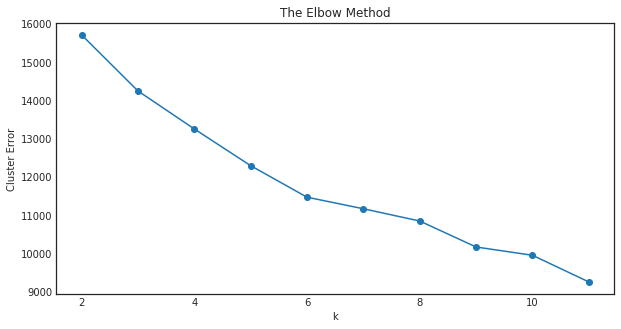

In [46]:
# In order to find the optimal number of K we use elbow method.
#Iterate on the number of clusters
cluster_error = []
range_n_clusters = range(2,12, 1)

for k in range_n_clusters:
    kmeanModel = KMeans(n_clusters=k, init='k-means++', n_init=11)
    kmeanModel.fit(X_tr_std)
    cluster_error.append(kmeanModel.inertia_)

#Build DataFrame
clusters_df = pd.DataFrame({ "num_clusters": range_n_clusters , 'cluster_error': cluster_error })

# Plot the elbow Plot
plt.figure(figsize=(10,5))
plt.plot(clusters_df.num_clusters, clusters_df.cluster_error, marker = "o")
plt.xlabel('k')
plt.ylabel('Cluster Error')
plt.title('The Elbow Method')
plt.show()

The best number of clusters from both the silhouette and the elbow technique perspective is six that will be the number of clusters used following this technique to cluster the customer base. The data will be clustered using kmeans and 6 clusters to get insights about the customer base. In this case, five, six and seven clusters have been tried being 6 the most relevant one.

In [73]:
#Cluster the data

#Number of clusters
num_clusters=6

#Cluster the information
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10).fit(X_tr_std)
labels = kmeans.labels_

#Glue back to original data
X_tr['clusters'] = labels
X_tr['gender'] = uns_final_dataset.gender
X_tr['age'] = uns_final_dataset.age
X_tr['group'] = uns_final_dataset.group

The predictive capacity of kmeans clustering with six clusters will be checked. In this case the predictive performance is very low 15% compared to the one obtained from the supervised models. Hence its use as a predictive tool is discarded for classification purposes.

In [74]:
clusters = kmeans.fit_predict(X_tr_std)
# Permute the labels
labels = np.zeros_like(clusters)
for i in range(num_clusters):
    mask = (clusters == i)
    labels[mask] = mode(y[mask])[0]

# Compute the accuracy
print(accuracy_score(y, labels))

0.148905109489


The data is aggregated by clusters and gender to inspect the average age per cluster. In all clusters the average age is the same standard deviation so it is not representative of the groups

In [76]:
#Determine pivot table
X_age = X_tr.pivot_table(values='age', index=["clusters","gender"], aggfunc=[np.mean,np.std])

#Print the age distribution
print(X_age)

                      mean        std
                       age        age
clusters gender                      
0        F       32.672855  10.781340
         M       32.184807   9.820802
1        F       33.658558  11.057825
         M       32.017841   9.501013
2        F       29.039909   8.840649
         M       29.472119   8.117748
3        F       34.412256  10.319291
         M       33.790176   9.582017
4        F       32.073540   9.964819
         M       31.114379   9.312043
5        F       32.718828  10.566830
         M       31.485859   9.206355


Information regarding the apps that people use is obtained from the clusters. It can be seen that three apps are the most used ones across clusters App 549, 706 and 548 that according to the documentation equate to Property Industry 1.0, Customized 1 and Industry tag. In the first and third cases they are construction inspection and tagging apps. The second case seems to be an app that is preinstalled in the phone. This might indicate the kind of population we are addressing although the calls are done from all around China. It could be the case that the sample is representative of a specific kind of population and the data has already being segmented reason why the average age in all clusters is nearly the same and around 30 years.

In [77]:
#Show only columns containing apps
filter_col = [col for col in X_tr if col.startswith('label_id')]

#Determine pivot table
X_apps = X_tr.pivot_table(values=filter_col, index=["clusters","gender"], aggfunc=np.sum)

#Print the apps that are more relevant
print(X_apps.idxmax(axis=1))

#Show table
print(X_apps)

clusters  gender
0         F         label_id_548
          M         label_id_548
1         F         label_id_548
          M         label_id_548
2         F         label_id_706
          M         label_id_706
3         F         label_id_713
          M         label_id_713
4         F         label_id_549
          M         label_id_549
5         F         label_id_549
          M         label_id_549
dtype: object
                 label_id_10  label_id_100  label_id_1005  label_id_1006  \
clusters gender                                                            
0        F               0.0           1.0            4.0            0.0   
         M               1.0           0.0            7.0            2.0   
1        F               0.0           1.0            1.0            0.0   
         M               0.0           1.0            3.0            0.0   
2        F               0.0           0.0            0.0            0.0   
         M               0.0           0.

In this case and following the same clustering scheme, only information relative to the phone brands has been kept. It appears that for the population under analysis, Xiaomi, OPPO and Samsung are the most popular ones being Vivo more popular among the female than male and Meizu more popular among male compared to female.

In [78]:
#Filter columns that only have the brands
filter_col = [col for col in X_tr if col.startswith('phone_brand')]

#Determine pivot table
X_phone_brand = X_tr.pivot_table(values=filter_col, index=["clusters",'gender'], aggfunc=np.sum)

#Print the brand that appears more times
print(X_phone_brand.idxmax(axis=1))

#Print the table for further analysis
print(X_phone_brand)

clusters  gender
0         F         phone_brand_samsung
          M         phone_brand_samsung
1         F          phone_brand_Xiaomi
          M          phone_brand_Xiaomi
2         F            phone_brand_OPPO
          M            phone_brand_OPPO
3         F          phone_brand_Huawei
          M          phone_brand_Huawei
4         F          phone_brand_Xiaomi
          M          phone_brand_Xiaomi
5         F          phone_brand_Xiaomi
          M          phone_brand_Xiaomi
dtype: object
                 phone_brand_Amazon  phone_brand_Bacardi  phone_brand_Bifer  \
clusters gender                                                               
0        F                      0.0                  0.0                1.0   
         M                      0.0                  1.0                7.0   
1        F                      0.0                  0.0                0.0   
         M                      0.0                  0.0                0.0   
2        F     

To be able to plot the different clusters PCA is run and the 2 principal components are extracted. In this case two are preferred to three components due to computational restrictions.

In [88]:
# mash the data down into 2 dimensions
ndimensions = 2

#Run PCA analysis and create 2 PC
pca = PCA(n_components=ndimensions, random_state=123)
pca.fit(X_tr_std)

#Transform the PC to arrays to build a dataframe
X_pca_array = pca.transform(X_tr_std)

#Build the dataframe with PCA components
X_pca = pd.DataFrame(X_pca_array, columns=['PC1','PC2']) # PC=principal component

#Build a dataframe copying the result obtained form PCA analysis
df_plot = X_pca.copy()

#Add to the dataframe the labels of the clusters and the information relative to the groups
df_plot['clusters'] = X_tr['clusters']
df_plot['groups'] = y 

#Print head
df_plot.head()

,PC1,PC2,clusters,groups
0,0.002032,-0.542698,3,5
1,-0.553635,-0.272186,3,0
2,0.002032,-0.542698,3,3
3,-0.553635,-0.272186,3,4
4,-0.429297,-0.257279,3,5


Once the PC are defined, a plot function is defined with the characteristics of the plot that is going to be done.

In [101]:
#Plot the clusters using PCA components
#Define the plotting function
def plotData(df, groupby):
    "make a scatterplot of the first two principal components of the data, colored by the groupby field"
    
    # make a figure with just one subplot specifying multiple subplots
    fig, ax = plt.subplots(figsize = (7,7))

    # color map
    cmap = mpl.cm.get_cmap('prism')

    #plot each cluster on the same graph.
    for i, cluster in df.groupby(groupby):
        cluster.plot(ax = ax, # need to pass this so all scatterplots are on same graph
                     kind = 'scatter', 
                     x = 'PC1', y = 'PC2',
                     color = cmap(i/(num_clusters-1)), # cmap maps a number to a color
                     label = "%s %i" % (groupby, i), 
                     s=30) # dot size
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(0, color='black')
    ax.set_title("Principal Components Analysis (PCA) of Mobile Operator Data")  
# forked from https://www.kaggle.com/bburns/iris-exploration-pca-k-means-and-gmm-clustering

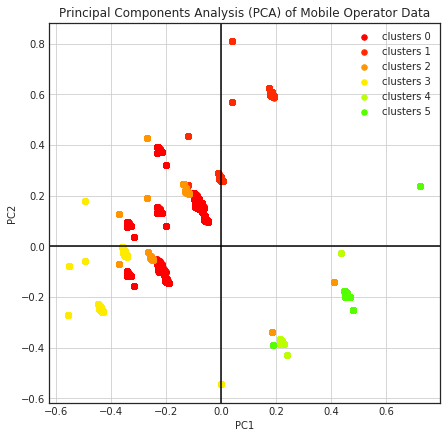

In [102]:
#Plot the clusters each datapoint was assigned to
plotData(df_plot, 'clusters')

From the plot above it can be seen that kmeans is not giving a lot of information about the clusters. The clusters appeared to be scattered due to the dimensionality of the data that is handled. Kmeans as k-nearest neighbors is based on Euclidean distance and nn this case the dimensionality of the problem is 281 and the Euclidean distance does not perform well with high dimensions as points that may be similar may have very large distances. This is the same problem that we found with the low performance of the K nearest neighbors algorithm as both are based on the same principle of Euclidean distances to look for similarity between points.

From the unsupervised analysis, it can be seen that clusters are not stable as every time that the “elbow” test was run different results were given which influenced the number of clusters to be used with kmeans. Furthermore, kmeans from the low performance that it has when classifying it’s discarded for classification purposes.

The other clustering techniques that have been tested are not suitable for this product. Affinity propagation is estimating the need of 14733 clusters while meanshift estimates 462, 2 or 1 when the bandwidth is changed. For this reason bith have been discarded.

### 7. Conclusion ###

The purpose of this product is to classify a subset of the population of China that uses a mobile operator based on the apps they have installed and that they used and the brand of the device they have. The classification takes into consideration gender and age range. The groups are distributed as follows (M=male, F=female being digits age limits): 'M39+' , 'M32-38', 'M29-31', 'M27-28', 'M23-26', 'M22-', 'F43+' ,'F33-42', 'F29-32', 'F27-28', 'F24-26', 'F23-'.

This demographic classification will allow the mobile operator “Talking Data” to sell added value services to marketing agencies and other companies so that they can improve the targeting of their marketing campaigns. Additionally it can be used to determine the most popular apps and brands depending on the age and gender.

For the elaboration of this product, datasets available in Kaggle have been used. The different files were scattered in different excel spreadsheet and the data was mainly categorical. The first action that has been done has been to merge into one dataset the relevant data required to build the classification models. In this case, information such as timestamp and lingitud and latitude has been excluded due to its quality. In most of the instances the data was either incomplete or incorrect. The former been set to zero increasing the number of calls significantly done at midnight and the second having the point (0,0) in the middle of the Ocean as one of the main locations where the devices have been tracked to.

The different datasets have been merged using the device_id as link between the dfferent demographic groups (containing information about gender and age range) apps and brand. Prior to being merged, dummy variables have been created and duplicates eliminated to avoid a disproportionate growth of the final dataset. As an example eliminating duplicates in phone brands has reduced the dataset from more than 2 million rows to 23k. The dummy variables have been created eliminating the first of them to void the dummy variable trap. Furthermore, those attributes identified as zero have been eliminated reducing the number of attributes from more than 600 to 274. The main reason why they were empty attributes is because they are phone brands that didn’t correspond to any of the devices in the dataset.

Exploratory data analysis shows how the number of apps active is roughly 50% of the apps installed. The population is concentrated in a range between 20 and 32 and that the age distribution. From an apps perspective, most of them have to do with financial products, banking and industrial (construction). From a brand perspective eight brands represent 90% of the sample in the Chinese market (Xaomi, Samsung, Huawei, Vivo, OPPO, Meizu, Coldpad y Lenovo). There is inequality in terms of gender distribution being the female users half the male users. Additionally the average age is 31 running from 25 to 35 in the 25% and 75%. In this case, the outliers outside of 1.5 the interquartile distance have not being discarded but has been one of the reasons why principal components have been used to selecte the best model for classification.

The different groups are unbalanced therefore resampling of the data has been done to avoid bias on the different classifiers that are used. This has increased the dataset to 40k rows manageable with the computing power available at google compute engine. The data presents low correlation between the attributes. Only one is between 0.4 and 0.5 being the correlation between others lower.

Features have been generated following features selection techniques such as kbest and random forest after scaling and normalizing the data. Kbest was giving the best scores being around 260 the features scoring over 1. Radom forest feature selection has been carried out. Only 16 score a meaningful score in this case. The % of variance explained by these features is not enough to achieve meaningful results from an accuracy perspective. The number of features has been selected following PCA. In this case, 120 PC are able to explain 98% of the variance. Additionally, logistic regression has been run through the components and lowering the number of principal components was giving low accuracy while increasing it was producing overfitting due to the noise they are introducing. As the main purpose of the model is to classify accurately users based on the apps usage and phone brand, the 120 PC have been used.

Model selection has been carried out splitting the sample into 70/30 training on 70% of the data (once transformed through PCA). Models have been trained and tuned using gridsearch and cross validation with five folds has been used to test them. Accuracy has been set as the main scoring parameter as there is no difference regarding false positive or negatives. In this case a customer that is misclassified will not receive the right ads making the campaign ineffective. The models, accuracy and computing effort (based in time required to fit the test set) tested are presented below:

1. ***Logistic Regression***. Accuracy: 95.72%. Computing effort: 3.3 min.
2. ***Linear Support Vector Classifier***. Accuracy: 94.99%. Computing Effort: 19.9 min.
3. ***Support Vector Classifier***. Accuracy: 92.29%. Computing effort: 57.3s.
4. ***Random Forest***. Accuracy: 81.04%. Computing Effort: 81.04%. Computing effort: 7.3 min.
5. ***Gradient Boosting Classifier***: Accuracy 79.25%. Computing effort: 90.2 min.
6. ***K-nearest neighbors***. Accuracy: 71.36%. Computing effort: 1.5 min.
7. ***SGD Classifier***. Accuracy: 47.88%. Computing effort: 9.5 min.
8. ***Naïve-Bayes Classifier***. Accuracy: 37.93%. Computing effort: 1.5s.

From the abovementioned results the best candidates are ***logistic regression*** due to its high accuracy, simplicity and low computational effort and ***support vector machine***. The latter presents a low computational effort due to the transformation of the features that has been done during the features generation. Regarding support vector machine, it presents scalability problems hence the best candidate remains the logistic regression algorithm.

Deep learning algorithms have been tested on the original normalized data and PCA. The choice has been to consider the original processed data as there was no significant differences in accuracy and neural networks are able to handle the data and generate the best features.

Different configurations of a neural network have been passed to achieve a higher accuracy than any of the previous models. In this case, the final configuration of the Multi-Layer Perceptron that achieves 98.91% is a sequential neural network with 6 hidden layer of 264 neurons and a dropout rate of 0.5 using batch normalization between layers. The activation function is “relu”, the loss is categorical crossentropy and the optimizer RMS. In this case, batches of 1250 have been used and 200 epochs have been used to optimize the accuracy of the model.

Although the accuracy obtained by this model is higher than the one achieved by other supervised models, the logistic regression and support vector machine models are the preferred ones as candidates for production. The neural network, although it gives a higher accuracy does not allow to distinguish the explanatory power of each of the features that are used. This is not required during image recognition but is necessary for the purpose of this exercise. Furthermore, the model is far more complex than the previous one and requires more computational power once it is in production.

For all this reasons the logistic regression and support vector machine models have been considered as the best candidates for production and among both Logistic Regression is the preferred option.

Unsupervised learning has been carried out to cluster the information trying to obtain meaningful insights from the original data. After normalizing the data affinity propagation, spectral clustering, mean shift and kmeans clustering techniques have been compared picking kmeans as the best one for this dataset. In this case affinity propagation was giving an excessive amount of clusters (over 1k), meanshift went from 462, 2 and 1 once the bandwidth was changed. Spectral clustering was compared to kmeans. Kmeans was offering better silhouette scores than spectral for a lower number of clusters. With the computing resources available and the dataset at hand, spectral clustering with 11 clusters (max shouette score) did not run. 

After running the elbow test, five, six and seven clusters were tested on kmeans. In this case, six clusters were picked as the best ones. From a classification perspective kmeans never gave a result higher than 20%. This is due to the characteristics of the problem as it is a high dimensional one (more than 200 dimensions for unsupervised clustering and more than 100 for supervised modelling, reason why KNN algorithm had a lower than expected performance).

Further analysis showed that the clusters and optimum number of clusters were not stable changing each time the model was run. At a high level the most meaningful insights obtained from clustering are that:

1. The most popular apps are related to construction and related to the brand of the phone: Property Industry 1.0, Industry tag and Customized 1.
2. The average age is 30 years old in every cluster.
3. It seems that the population in the dataset are related to construction companies
4. Among the population of the dataset the most popular phone brands are: Xiaomi, OPPO and Samsung are the most popular ones being Vivo more popular among the female than male and Meizu more popular among male compared to female.

Due to the characteristics of the data and high dimensionality of the problem the graphical representation of the clusters is highly scattered which does not give any relevant information about them. Hence, from a classification purpose the best model to use based on its accuracy is Logistic Regression which can compete in terms of accuracy with deep learning models but is a better candidate for production. From a clustering perspective, clustering is not offering any relevant information and cannot be used for classification.